In [1]:
import sys, os, pickle
from joblib import Parallel, delayed
import pandas as pd
from jumpmodels.utils import filter_date_range
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.sparse_jump import SparseJumpModel
from sklearn.preprocessing import StandardScaler
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import exceptions 
from scipy.optimize import brentq
import cvxpy as cp
from scipy import stats

#sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
# sys.path.append('/Users/vlad/Desktop/git/Masters-Thesis-VRI-VP/vic_new')         # for mac vlad
from feature_set_v2 import MergedDataLoader 

In [2]:
# 0) Global parameters ------------------------------------------------------------------
REFIT_FREQ        = "ME"        
MIN_TRAINING_YEARS= 8
MAX_TRAINING_YEARS= 12
INITIAL_TRAIN_START = "2002-05-31"
test_start        = "2017-01-01"

# Pick method to drive backtest: "grid", "bayes" or "history" ---------------------------
cv_choice = "bayes"

# Paths & tickers -----------------------------------------------------------------------
script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", "..", "..","..", "..","..",".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   # used everywhere

# grid_df    = pd.read_parquet("cv_params_grid.parquet")
# bayes_df   = pd.read_parquet("cv_params_bayes_v2.parquet") # v2 is the one searching between 20-2000
# history_df = pd.read_parquet("cv_params_history.parquet")

In [3]:
# # ──────────────────────────────────────────────────────────────
# # HYPERPARAMETERS
# # ──────────────────────────────────────────────────────────────
# df_map = {
#     "grid":    grid_df,
#     "bayes":   bayes_df,
#     "history": history_df
# }
# cv_df = df_map[cv_choice]

# # ─────────────────────────────────────────────────────
# # HYPERPARAMETER SMOOTHING SETUP
# # ─────────────────────────────────────────────────────
# # pick one
# SMOOTH_METHOD = "none"   # options: "none", "rolling_median", "ewma"
# SMOOTH_WINDOW = 3        # # of folds to include in the window
# # ─────────────────────────────────────────────────────

# # … right after cv_df = df_map[cv_choice] …
# cv_df = cv_df.sort_values(["factor","date"])

# if SMOOTH_METHOD == "none":
#     # simply copy original λ & κ forward
#     cv_df["sm_lambda"] = cv_df["best_lambda"]
#     cv_df["sm_kappa"]  = cv_df["best_kappa"]

# elif SMOOTH_METHOD == "rolling_median":
#     # Centered rolling median
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )

# elif SMOOTH_METHOD == "ewma":
#     # Exponential‐weight moving average
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )

# else:
#     raise ValueError(f"Unknown SMOOTH_METHOD {SMOOTH_METHOD!r}")

# # round κ back to integer
# cv_df["sm_kappa"] = cv_df["sm_kappa"].round().astype(int)

# # overwrite with the chosen values
# cv_df["best_lambda"] = cv_df["sm_lambda"]
# cv_df["best_kappa"]  = cv_df["sm_kappa"]

# # (optional) drop helpers
# cv_df.drop(columns=["sm_lambda","sm_kappa"], inplace=True)

# # ─────────────────────────────────────────────────────
# # Now build saved_hyperparams exactly as before
# # ─────────────────────────────────────────────────────
# saved_hyperparams = {}
# for fac in factors:
#     sub = cv_df[cv_df["factor"] == fac].sort_values("date")
#     saved_hyperparams[fac] = [
#         {
#             "date":      row["date"],
#             "new_lambda": row["best_lambda"],
#             "new_kappa":  row["best_kappa"]
#         }
#         for _, row in sub.iterrows()
#     ]


In [4]:
# ──────────────────────────────────────────────────────────────
# DATA‑LOADING BLOCK  (pulled from old notebook)
# ──────────────────────────────────────────────────────────────

# 1) Load full data for every factor + market ------------------------------------------------
factor_data_dict  = {}
factor_returns_ls = []

for fac in factors:
    print(f"Loading data for {fac}")
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()

    common_idx = (data.X.index
                  .intersection(data.ret_ser.index)
                  .intersection(data.market_ser.index))

    X_full        = data.X.loc[common_idx]
    fac_ret_full  = data.ret_ser.loc[common_idx]
    mkt_ret_full  = data.market_ser.loc[common_idx]
    active_ret    = fac_ret_full - mkt_ret_full

    factor_data_dict[fac] = {
        "X"        : X_full,
        "fac_ret"  : fac_ret_full,
        "mkt_ret"  : mkt_ret_full,
        "active_ret": active_ret,
    }
    factor_returns_ls.append(fac_ret_full)

# save last loop’s mkt_ret_full as market series
all_market_ret = mkt_ret_full

# 2) Assemble master return dataframe (factors + Market + rf) -------------------------------
full_factors_df = pd.concat(factor_returns_ls, axis=1).dropna()
full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
full_df.columns = factors + ["Market"]

# risk‑free
etf_df   = pd.read_csv(etf_file, index_col=0, parse_dates=True).dropna().sort_index()
rf_ser   = etf_df["rf"]
full_df  = pd.concat([full_df, rf_ser], axis=1).dropna()
full_df.columns = factors + ["Market", "rf"]

# 3) Define test index (everything from 2017‑01‑01 on) --------------------------------------
test_slice = full_df.loc[test_start:]
test_index = test_slice.index.sort_values()
# ──────────────────────────────────────────────────────────────


Loading data for iwf
Loading data for mtum
Loading data for qual
Loading data for size
Loading data for usmv
Loading data for vlue


In [7]:
# ------------------------------------------------------------
# 1  BUILD & CACHE FACTOR‑VIEWS  (run once, takes minutes)
# ------------------------------------------------------------
VIEWS_FILE = "regimeagnostic.pkl" # "SAVEfactor_views.pkl" is the views for the outperforming sharpe run
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):

    # ---------- helpers ----------
    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 

    # ---------- data ----------
    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)

    # ---------- preprocess ----------
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)

    # ---------- fit SJM ----------
    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)

    # regime‑level abs returns
    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252

    # ---------- online prediction for test dates ----------
    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                          # all history up to 'day'
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)    # fit on *all* history

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]

    # assemble mini‑df for this factor & period
    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))
    out["ann_abs_ret"] = out["state"].map(abs_ret)
    return fac, out

def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]

        # ---- parallel over factors ----
        jobs = []
        for fac in factors:
            # latest hyperparams before refit_date
            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)

    # concat & tidy
    for fac in factors:
        views[fac] = (pd.concat(views[fac])
                      .sort_index()
                      .loc[:,["state","ann_abs_ret"]])
    return views


# --------- build or load ----------         
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE):
    factor_views = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE, "wb") as f:
        pickle.dump(factor_views, f)
else:
    with open(VIEWS_FILE, "rb") as f:
        factor_views = pickle.load(f)



In [8]:
for fac in factor_views:
    # 1) pull & sort your raw active return series
    daily_active = factor_data_dict[fac]["active_ret"].sort_index()

    # 2) build the expanding mean → annualized
    cum_mean_annual = daily_active.expanding().mean() * 252

    # 3) stick the raw active_ret into your factor_views DF
    factor_views[fac]["active_ret"] = (
        cum_mean_annual
        .reindex(factor_views[fac].index, method="ffill")
    )


In [7]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import math

# facs = list(factor_views.keys())
# n, cols = len(facs), 3
# rows = math.ceil(n/cols)

# fig, axes = plt.subplots(rows, cols,
#                          figsize=(cols*4, rows*3.5),
#                          sharex=True, sharey=True)

# for ax, fac in zip(axes.flatten(), facs):
#     df = factor_views[fac]
#     for state, col, lbl in zip(
#         [0,1], ['tab:blue','tab:orange'], ['state 0','state 1']
#     ):
#         sel = df['state'].eq(state)
#         ax.plot(df.index[sel], df.loc[sel,'active_ret'],
#                 color=col, lw=1.5, label=lbl)
#     ax.set_title(fac.upper(), fontsize=12)
#     ax.set_ylim(-0.03, 0.05)
#     ax.grid(alpha=0.25)
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# # rotate & align all x-labels    
# for ax in axes.flatten():
#     plt.setp(ax.xaxis.get_majorticklabels(),
#              rotation=45, ha='right', fontsize=8)

# # drop unused subplots
# for ax in axes.flatten()[n:]:
#     fig.delaxes(ax)

# # single legend below
# handles, labels = axes.flatten()[0].get_legend_handles_labels()
# fig.legend(handles, labels,
#            loc='lower center',
#            ncol=2, frameon=False, fontsize=10)

# fig.suptitle('Annualized Absolute Return by Regime', fontsize=14, y=1.02)
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.show()


In [37]:
# ------------------------------------------------------------
# 2  FAST BLACK‑LITTERMAN FUNCTION  (run as often as you like)
# ------------------------------------------------------------

from pypfopt import EfficientFrontier
from pypfopt.exceptions import OptimizationError

def ewm_covariance(returns, halflife=126, min_periods=60):
    ewm_cov = returns.ewm(halflife=halflife,
                          adjust=False,
                          min_periods=min_periods).cov()
    if returns.empty: return pd.DataFrame()
    return ewm_cov.loc[returns.index[-1]]

def make_shift_series(returns_df, views=None, factors=None, mode=None):
    """
    mode: one of {None, "shift", "month_end"}
    """
    if mode is None:
        return None
    elif mode == "shift":
        # your existing “state‐change” logic
        return detect_state_shifts(views, factors).reindex(returns_df.index, fill_value=False)
    elif mode == "month_end":
        # rebalance on the last trading day of every month
        return returns_df.index.to_series().dt.is_month_end
    elif mode == "quarter_end":
        # rebalance on the last trading day of every month
        return returns_df.index.to_series().dt.is_quarter_end
    elif mode == "half_year_end":
        return returns_df.index.to_series().dt.month.isin([6, 12]) & returns_df.index.to_series().dt.is_month_end
    elif mode == "year_end":
        # rebalance on the last trading day of every month
        return returns_df.index.to_series().dt.is_year_end
    else:
        raise ValueError(f"unknown shift mode {mode!r}")

def detect_state_shifts(views, factors):
    # 1 col per factor with the model‑state
    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)
    # True when *any* factor changes state vs. the day before
    return state_df.ne(state_df.shift()).any(axis=1)

# ---------- helper: dict -> (P,Q) for relative views ----------
def make_relative_views(view_dict, assets, benchmark="Market"):
    """
    Convert {'fac': active_ret, ...} into (P,Q) so that
    E[fac] - E[benchmark] = active_ret  for every factor.
    """
    if benchmark not in assets:
        raise ValueError(f"Benchmark {benchmark!r} not in trade universe")

    n = len(assets)
    k = len(view_dict)
    P = np.zeros((k, n))
    Q = np.zeros(k)

    for i, (fac, v) in enumerate(view_dict.items()):
        if fac not in assets:
            continue                      # ignore missing factors
        P[i, assets.index(fac)]       = 1
        P[i, assets.index(benchmark)] = -1
        Q[i] = v                       # the expected active return
    return P, Q


def bl_max_sharpe_te(cov_hist, pi, views, tau, delta,
                     w_bmk, te_target, bounds, rf,
                     use_bl_cov=False):

    """
    Returns target weights *over trade_assets* (no cash leg).
    Falls back to the CVXPY excess-return solver if max_sharpe errors.
    """
    # 1) Black-Litterman → implied mu & Sigma
    P, Q = make_relative_views(views, list(w_bmk.index), benchmark="Market")
    bl = BlackLittermanModel(cov_hist, pi=pi, tau=tau,
                             delta=delta, P=P, Q=Q)
    Sigma = bl.bl_cov() if use_bl_cov else cov_hist
    mu    = bl.bl_returns()
    n     = len(mu)
    bmk_w = w_bmk.values
    Σ     = Sigma.values

    # 2) set up EF + TE + bounds
    ef = EfficientFrontier(mu, Sigma)
    ef.add_constraint(lambda w: cp.quad_form(w - bmk_w, Σ) <= te_target**2)
    # ef.add_constraint(lambda w: cp.norm1(w) <= 1) # for thew config when we dont want to lever with short proceeds
    # ef.add_constraint(lambda w: cp.sum(cp.pos((w))) <= 1) # or this one - not sure which is better
    for i, (lo, hi) in enumerate(bounds):
        ef.add_constraint(lambda w, i=i, lo=lo: w[i] >= lo)
        ef.add_constraint(lambda w, i=i, hi=hi: w[i] <= hi)

    # 3) try max_sharpe, else fallback to CVXPY
    try:
        raw_w = ef.max_sharpe(risk_free_rate=rf)
    except (OptimizationError, ValueError):
        w_var = cp.Variable(n)
        w_act = w_var - bmk_w
        prob = cp.Problem(
            cp.Maximize((mu.values - rf) @ w_var),
            [
                cp.sum(w_var) == 1,                                         # change to 'cp.norm1(w_var) <= 1' or 'cp.sum(cp.pos(w_var)) <= 1' when we dont want to lever with short proceeds
                w_var >= np.array([lo for lo, hi in bounds]),
                w_var <= np.array([hi for lo, hi in bounds]),
                cp.quad_form(w_act, Σ) <= te_target**2
            ]
        )
        prob.solve(solver="SCS")
        raw_w = dict(zip(w_bmk.index, w_var.value))

    return pd.Series(raw_w, index=w_bmk.index)


def run_bl_with_drift(views, returns_df, full_df,
                      shift_series=None,
                      tau=0.05, delta=2.5,
                      te_target=0.05,
                      trade_market=True,
                      use_bl_cov=False,
                      allow_market_short=False,
                      allow_factor_short=False,
                      use_bl_prior=False,
                      fallback_strategy="HOLD_RFR",
                      tcost=0.0007,
                      initial_capital=1_000_000,
                      shift_mode=None):
    """
    Returns:
      w_view   -> DataFrame of *target* weights from the optimizer
      w_actual -> DataFrame of *actual* daily weights, drifting unless rebalance
      rets     -> Series of daily portfolio returns (in decimal, e.g. 0.01 = 1%)
    """

    if shift_series is None and shift_mode is not None:
        shift_series = make_shift_series(returns_df,
                                         views=views,
                                         factors=list(views),
                                         mode=shift_mode)
        # always rebalance on first day
        shift_series.iloc[0] = True

    assets  = returns_df.columns.tolist()
    factors = list(views.keys())

    # Decide which assets can be traded
    if trade_market:
        trade_assets = [a for a in assets if a != "rf"]
    else:
        trade_assets = [a for a in assets if a not in {"rf", "Market"}]

    cash_asset = "rf"

    # Bounds
    bounds = []
    for a in trade_assets:
        if a == "Market":
            bounds.append((-.3, .3) if allow_market_short else (0, 0.3))
        else:
            bounds.append((-.3, .3) if allow_factor_short else (0, 0.3))

    # Prepare DataFrames
    w_view   = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)
    w_actual = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)

    # Track positions in “dollar” terms
    positions = pd.Series(0.0, index=trade_assets + [cash_asset])
    capital   = initial_capital

    # Series of daily returns, e.g. +0.005 = +0.5%
    rets = pd.Series(0.0, index=returns_df.index)

    for i, t in enumerate(returns_df.index):
        old_capital = capital  # Store capital before today’s returns

        # 1) Realize today's P&L from yesterday’s positions
        if i > 0:
            day_ret = returns_df.loc[t, trade_assets + [cash_asset]]
            daily_pnl = (positions[trade_assets] * day_ret[trade_assets]).sum() \
                        + positions[cash_asset] * day_ret[cash_asset]

            capital += daily_pnl
            # convert P&L → daily return = P&L / yesterday’s capital
            rets.loc[t] = daily_pnl / old_capital

        # 2) Decide if we rebalance today
        do_rebalance = False
        if i == 0:
            do_rebalance = True
        elif shift_series is not None and shift_series.loc[t]:
            do_rebalance = True

        # 3) If rebalancing, solve for new “view” weights
        if do_rebalance:
            hist = full_df[trade_assets].loc[:t].iloc[:-1]
            cov  = ewm_covariance(hist) * 252

            if cov.empty or cov.isna().any().any():
                w_view.loc[t, trade_assets] = 0.0
                w_view.loc[t, cash_asset]   = 1.0  # 100% cash
            else:
                # Build a quick "light" BlackLittermanModel
                if use_bl_prior:
                    market_caps  = {etf: 1.0 for etf in trade_assets}
                    prior_for_bl = market_implied_prior_returns(market_caps, delta, cov)
                else:
                    prior_for_bl = "equal"

                q = {fac: views[fac].loc[t, "active_ret"] for fac in factors}
                rf_annual = returns_df.loc[t, cash_asset] * 252

                # Build a quick "light" BlackLittermanModel
                q_abs = {fac: views[fac].loc[t, "ann_abs_ret"] for fac in factors}

                bl0 = BlackLittermanModel(
                    cov,
                    pi=prior_for_bl,
                    tau=tau,
                    delta=delta,
                    absolute_views=q_abs
)

                # 2) Check fallback if all implied returns ≤ rf
                if (
                    fallback_strategy != "NO_FALLBACK"
                    and (bl0.bl_returns() <= rf_annual).all()
                ):
                    # “Risk-off” scenario
                    w_view.loc[t, trade_assets] = 0.0  # all 0
                    if fallback_strategy == "HOLD_RFR":
                        w_view.loc[t, cash_asset] = 1.0  # 100% in cash
                    elif fallback_strategy == "SHORT_MARKET" and "Market" in trade_assets:
                        w_view.loc[t, "Market"]   = -1.0
                        w_view.loc[t, cash_asset] = 1.0
                    # skip the main BL max-sharpe
                else:
                    # normal BL
                    w_opt = bl_max_sharpe_te(
                        cov,
                        pi=prior_for_bl,
                        views=q,
                        tau=tau,
                        delta=delta,
                        w_bmk=pd.Series(1 / len(trade_assets), index=trade_assets),
                        te_target=te_target,
                        bounds=bounds,
                        rf=rf_annual,
                        use_bl_cov=use_bl_cov
                    )
                    w_view.loc[t, trade_assets] = w_opt
                    w_view.loc[t, cash_asset]   = 1 - w_opt.sum()


            # 4) Convert new “view weights” → actual $ positions
            new_positions = capital * w_view.loc[t]

            # transaction cost
            if tcost > 0 and i > 0:
                trades = (new_positions - positions).abs().sum()
                cost   = trades * tcost
                capital -= cost
                # --- ADJUST return to include cost drag ---
                # old_capital was saved at the top of the loop
                rets.loc[t] = (capital - old_capital) / old_capital
                # recompute positions off the net capital
                if capital > 0:
                    new_positions = capital * w_view.loc[t]

            positions = new_positions

        else:
            # Not rebalancing → copy forward yesterday’s “view” weights
            if i > 0:
                w_view.loc[t] = w_view.iloc[i - 1]

        # 5) Actual weights
        if capital > 0:
            w_actual.loc[t] = positions / capital
        else:
            w_actual.loc[t] = 0.0

    return w_view, w_actual, rets


In [38]:
# ------------------------------------------------------------
# 3  QUICK EXPERIMENTS
# ------------------------------------------------------------
def annualized_sharpe(r):          # helper
    return (r.mean() / r.std()) * np.sqrt(252)

def ann_turnover(w):
    daily_turn = w.diff().abs().sum(axis=1).mean()
    return daily_turn * 252

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

mode = "year_end" # None (daily), "shift" or "month_end"

cfgs = [

     dict(label="Base model 4% TE, monthly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="month_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE, monthly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="month_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE, monthly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="month_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE, monthly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="month_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"),    

     dict(label="Base model 4% TE, quarterly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="quarter_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE, quarterly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="quarter_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE, quarterly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="quarter_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE, quarterly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="quarter_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"), 

     dict(label="Base model 4% TE, half-yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="half_year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE, half-yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="half_year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE, half-yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="half_year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE, half-yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="half_year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"), 

     dict(label="Base model 4% TE, yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE, yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE, yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE, yearly",  tau=0.05, delta=2.5,shift_series=None, trade_market=True, shift_mode="year_end",
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"), 

]


run_results = {}
for c in cfgs:
    label = c.pop("label")
    w_view, w_act, daily_returns = run_bl_with_drift(
        factor_views,  # factor views
        test_df,       # returns_df
        full_df,       # full_df
        **c
    )
    
    run_results[label] = {
        "returns":        daily_returns,  # decimal daily returns
        "weights_view":   w_view,
        "weights_actual": w_act,
        "cfg":            c
    }
 




C:\Users\victo\AppData\Local\Temp\ipykernel_17072\2357481679.py:141: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
C:\Users\victo\AppData\Local\Temp\ipykernel_17072\2357481679.py:141: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
C:\Users\victo\AppData\Local\Temp\ipykernel_17072\2357481679.py:141: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
C:\Users\victo\AppData\Local\Temp\ipykernel_17072\2357481679.py:141: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
C:\Users\victo\AppData\L

In [ ]:
run_results

In [ ]:
import pickle

# # # # # # 1) SAVE # # # # # # 

# with open("run_results_monthtrade.pkl", "wb") as f:
#     pickle.dump(run_results, f)


# # # # # # 1) LOAD # # # # # # 

# with open("run_results_monthtrade.pkl", "rb") as f:
#     run_results = pickle.load(f)

# test_df = full_df.loc[test_index]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import SelectMultiple, Dropdown, ToggleButtons, VBox, HBox, interact

import importlib, jumpmodels.plot as jmplot
importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded

# === Cleaner labels ===
strategy_labels = {
    "Benchmark (Q-Rebalanced EW)": "Benchmark (Q-Rebalanced EW)",
    "Benchmark (Market Buy-Hold)": "Benchmark (Market Buy-Hold)",
    "Base model 1% TE": "Dynamic Allocation (1 per cent TE)",
    "Base model 2% TE": "Dynamic Allocation (2 per cent TE)",
    "Base model 3% TE": "Dynamic Allocation (3 per cent TE)",
    "Base model 4% TE": "Dynamic Allocation (4 per cent TE)",
    "L/S 1% TE": "Dynamic Long-Short Allocation (1 per cent TE)",
    "L/S 2% TE": "Dynamic Long-Short Allocation (2 per cent TE)",
    "L/S 3% TE": "Dynamic Long-Short Allocation (3 per cent TE)",
    "L/S 4% TE": "Dynamic Long-Short Allocation (4 per cent TE)",
    "Risk-off 1% TE": "Dynamic Allocation with Risk-Off (1 per cent TE)",
    "Risk-off 2% TE": "Dynamic Allocation with Risk-Off (2 per cent TE)",
    "Risk-off 3% TE": "Dynamic Allocation with Risk-Off (3 per cent TE)",
    "Risk-off 4% TE": "Dynamic Allocation with Risk-Off (4 per cent TE)",
}

run_results = {
    strategy_labels.get(orig, orig): vals
    for orig, vals in run_results.items()
}

factor_labels = {
    "iwf":  "IWF (Growth factor)",
    "mtum": "MTUM (Momentum factor)",
    "qual": "QUAL (Quality factor)",
    "size": "SIZE (Size factor)",
    "usmv": "USMV (Low-volatility factor)",
    "vlue": "VLUE (Value factor)",
    "Market": "Market",
    "rf":     "Risk-free"
}


# --------------------------------------------------------------------
# 1) Clean out old EW from run_results
# --------------------------------------------------------------------
for k in list(run_results):
    if k.startswith("Benchmark (Q-Rebalanced EW)"):
        run_results.pop(k)

# --------------------------------------------------------------------
# 2) Rebuild the EW benchmark for your test set
# --------------------------------------------------------------------
TCOST = 0.0007
df    = etf_df.loc[test_index.intersection(etf_df.index)].drop(columns=["rf"])
n     = df.shape[1]

# Quarter-end dates
first = df.index[0]
qends = df.index.to_series().resample("QE").last().dropna().index
if first not in qends:
    qends = qends.insert(0, first)

ew_rets    = pd.Series(index=df.index, dtype=float)
ew_weights = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
prev_w     = np.zeros(n)

for i in range(len(qends) - 1):
    start, end = qends[i], qends[i + 1]
    period = df.loc[(df.index > start) & (df.index <= end)]
    w      = np.ones(n) / n
    for j, day in enumerate(period.index):
        ew_weights.loc[day] = w
        r_i  = period.loc[day].values
        tc   = TCOST * np.abs(w - prev_w).sum() if j == 0 else 0.0
        p    = w.dot(r_i) - tc
        ew_rets.loc[day] = p
        w    = w * (1 + r_i)
        if (1 + p) != 0:
            w /= (1 + p)
    prev_w = w.copy()

ew_rets = ew_rets.fillna(0)

run_results["Benchmark (Q-Rebalanced EW)"] = {
    "returns": ew_rets,  # decimal daily returns
    "weights_view": ew_weights,    # no drift in a simple model
    "weights_actual": ew_weights
}

# --------------------------------------------------------------------
# 3) Add "Market Buy-Hold" benchmark
# --------------------------------------------------------------------
market_rets = etf_df["Market"].loc[test_index.intersection(etf_df.index)]
market_w    = pd.DataFrame(index=market_rets.index, columns=["Market"])
market_w["Market"] = 1.0

run_results["Benchmark (Market Buy-Hold)"] = {
    "returns": market_rets, # decimal daily returns for Market
    "weights_view": market_w,
    "weights_actual": market_w
}

# --------------------------------------------------------------------
# 4) Reindex everything to the full test calendar
# --------------------------------------------------------------------
full_idx = test_index

for lab, res in run_results.items():
    # Reindex returns
    res["returns"] = res["returns"].reindex(full_idx).fillna(0)
    
    # Reindex view + actual if present
    if "weights_view" in res:
        res["weights_view"] = res["weights_view"].reindex(full_idx).ffill().fillna(0)
    if "weights_actual" in res:
        res["weights_actual"] = res["weights_actual"].reindex(full_idx).ffill().fillna(0)


# --------------------------------------------------------------------
# 5) Build “active dates” if needed
# --------------------------------------------------------------------
active = pd.Index([])
for cfg in run_results.values():
    # For single-weights cases:
    wdf = cfg.get("weights")
    if wdf is not None:
        idx = wdf.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    # For drifting-weights cases:
    wv  = cfg.get("weights_view")
    wa  = cfg.get("weights_actual")
    if wv is not None:
        idx = wv.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    if wa is not None:
        idx = wa.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)

active = active.sort_values()
ew_w = ew_weights.loc[ew_weights.index.isin(active)]

# --------------------------------------------------------------------
# 6) Interactive widgets
# --------------------------------------------------------------------
labels = list(run_results.keys())

cmp = SelectMultiple(
    options=labels,
    value=tuple(labels[:2]) if len(labels) >= 2 else tuple(labels),
    description="Compare:",
    rows=min(8, len(labels)),
    style={"description_width": "70px"}
)
wgt = Dropdown(
    options=labels,
    value=labels[0],
    description="Weights:",
    style={"description_width": "70px"}
)
sign = ToggleButtons(
    options=[("Both", "both"), ("Positive", "pos"), ("Negative", "neg")],
    value="both",
    description="Show:",
    style={"description_width": "70px"}
)

def sharpe(returns):
    return returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan

def _update(compare, weights_cfg, sign_filter):
    if not compare:
        print("Pick ≥1 config.")
        return
    
    # 1) Always include benchmarks
    benchmarks = []
    for bench_name in ["Benchmark (Q-Rebalanced EW)", "Benchmark (Market Buy-Hold)"]:
        if bench_name in run_results:
            benchmarks.append(bench_name)

    # 2) Build dictionary
    data = {}
    for bmk in benchmarks:
        data[bmk] = run_results[bmk]["returns"]
    for lab in compare:
        data[lab] = run_results[lab]["returns"]

    ret_df = pd.DataFrame(data).reindex(full_idx, fill_value=0)

    # 3) Plot cumulative returns
    plot_cumret_compounded(ret_df)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [lab.replace("%", "%%") for lab in labels]
    plt.legend(handles, labels)
    plt.grid(True)
    plt.show()


    # 4) Print Sharpe for all displayed
    # print("Annualised Sharpe ratios (incl. benchmarks):")
    # for col in ret_df.columns:
    #     sr = sharpe(ret_df[col])
    #     print(f"  {col:<45s}: {sr:.3f}")

    # 5) (Weights plotting stays unchanged)

    #    If run_results[weights_cfg] has separate 'weights_view' & 'weights_actual',
    #    do two separate stackplots: "View Weights" first, then "Actual Weights."
    res = run_results[weights_cfg]
    wv = res.get("weights_view")
    wa = res.get("weights_actual")

    # rename the columns so your legend shows e.g. "IWF (Growth factor)" instead of "iwf"
    wv = wv.rename(columns=factor_labels)
    wa = wa.rename(columns=factor_labels)


    if wv is not None and wa is not None:
        # Possibly filter positive/negative
        if sign_filter == "pos":
            wv = wv.where(wv > 0, 0)
            wa = wa.where(wa > 0, 0)
        elif sign_filter == "neg":
            wv = wv.where(wv < 0, 0)
            wa = wa.where(wa < 0, 0)


        # (A) View weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wv.index, wv.T.values, labels=wv.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),  # outside the plot to the right
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

        # (B) Actual (drifted) weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wa.index, wa.T.values, labels=wa.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
plt.show()


ui = VBox([HBox([cmp, wgt, sign])])
interact(_update, compare=cmp, weights_cfg=wgt, sign_filter=sign)


# --------------------------------------------------------------------
# 9) Final table with all your stats
# --------------------------------------------------------------------
def ann_return(r):
    total = (1 + r).prod()
    n = r.shape[0]
    return total**(252/n) - 1 if total>0 else np.nan

def ann_volatility(r):
    return r.std() * np.sqrt(252)

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return -dd.min()

def sortino(r, mar=0.0):
    neg = r[r < mar]
    if neg.empty:
        return np.nan
    downside = neg.std()
    return (r.mean() - mar) / downside * np.sqrt(252) if downside > 0 else np.nan

def calmar(r):
    ar = ann_return(r)
    dd = max_drawdown(r)
    return ar / dd if dd>0 else np.nan

def information_ratio(series, bench):
    a, b = series.align(bench, join="inner")
    active = a - b
    return sharpe(active)

def total_turnover(weights):
    w = weights.ffill().fillna(0)
    daily_t = w.diff().abs().sum(axis=1)
    return daily_t.mean() * 252 * 0.5

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

def ann_turnover(weights, rebalance_flags=shift_days):
    """One-way annual turnover (% of portfolio traded per calendar year)."""
    w = weights.ffill().fillna(0)

    # turnover on every day (buys + sells, counted once)
    daily = 0.5 * w.diff().abs().sum(1)

    # keep only the days you actually trade
    # daily = daily[rebalance_flags]

    # sum the trades that fall in each calendar year
    yearly = daily.resample("YE").sum()          # “A” = year-end

    return yearly.mean()                        # single headline number


# Build table
rf_daily = etf_df["rf"].reindex(full_idx).fillna(0)
rows = []
for lab, res in run_results.items():
    r = res["returns"]  # daily decimal returns
    r_ex = r - rf_daily
    wdf = res.get("weights_actual", res.get("weights_view", None))
    
    row = {}
    row["Strategy"] = lab
    row["Ann.Return"]   = ann_return(r)
    row["Ann.Ex.Return"]= ann_return(r_ex)
    row["Ann.Ex.Risk"]  = ann_volatility(r_ex)
    row["Ex.Sharpe"]    = sharpe(r_ex)
    row["MaxDD"]        = max_drawdown(r)
    row["Sortino"]      = sortino(r)
    row["Calmar"]       = calmar(r)

    # info ratio vs. your Q-Rebalanced EW, if it’s in run_results
    if "Benchmark (Q-Rebalanced EW)" in run_results:
        row["InfoRatio"] = information_ratio(r, run_results["Benchmark (Q-Rebalanced EW)"]["returns"])
    else:
        row["InfoRatio"] = np.nan

    if wdf is not None:
        row["Turnover"] = ann_turnover(wdf)
    else:
        row["Turnover"] = np.nan

    rows.append(row)

df_stats = pd.DataFrame(rows)
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.3f}"))




interactive(children=(SelectMultiple(description='Compare:', index=(0, 1), options=('Base model 4% TE, monthly…

                     Strategy  Ann.Return  Ann.Ex.Return  Ann.Ex.Risk  Ex.Sharpe  MaxDD  Sortino  Calmar  InfoRatio  Turnover
    Base model 4% TE, monthly       0.125          0.101        0.208      0.566  0.361    0.813   0.347      0.621     1.294
    Base model 3% TE, monthly       0.122          0.097        0.203      0.560  0.361    0.807   0.338      0.582     1.220
    Base model 2% TE, monthly       0.117          0.093        0.199      0.545  0.373    0.786   0.314      0.442     1.161
    Base model 1% TE, monthly       0.114          0.089        0.190      0.546  0.379    0.785   0.300      0.331     1.051
  Base model 4% TE, quarterly       0.121          0.097        0.200      0.560  0.358    0.804   0.338      0.501     1.089
  Base model 3% TE, quarterly       0.117          0.093        0.195      0.553  0.358    0.798   0.328      0.432     1.045
  Base model 2% TE, quarterly       0.112          0.088        0.193      0.532  0.376    0.768   0.298      0.271   

In [12]:
# Return contributions

import matplotlib.pyplot as plt
# import importlib, jumpmodels.plot as jmplot
# importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded, check_axes

def plot_factor_contributions(strategy_name, run_results, returns_df, factor_labels):
    # get raw weights
    w_view = run_results[strategy_name]["weights_actual"]

    # decide which cols to drop
    exclude = set()
    if "Risk-Off" not in strategy_name:
        exclude |= {"rf"}

    # pick only remaining factor cols
    factor_cols = [
        c for c in w_view.columns
        if c in returns_df.columns and c not in exclude
    ]

    # slice returns & align weights
    r_df   = returns_df[factor_cols]
    w_view = w_view[factor_cols].reindex(r_df.index).ffill().fillna(0)

    # compute daily P&L contributions
    contrib          = w_view.shift(1).mul(r_df)
    contrib.iloc[0]  = 0.0

    # rename to full labels
    contrib = contrib.rename(columns=factor_labels)
    w_plot  = w_view.rename(columns=factor_labels)

    # 1) cumulative-return plot
    cumret = (1 + contrib).cumprod()

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each column
    for col in cumret.columns:
        ax.plot(cumret.index, cumret[col], label=col, linewidth=0.8)

    # Legend, grid, labels, and styling
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=False)
    ax.grid(True)
    ax.set_ylabel("Cumulative return", fontsize=20)
    ax.tick_params(axis='both', labelsize=20)

    fig.tight_layout()
    fig.savefig("ret_contribution.png", dpi=300) 


    plt.show()

    # 2) weights stackplot
    # fig, ax = plt.subplots(figsize=(8, 6))
    # ax.stackplot(
    #     w_plot.index,
    #     *w_plot.values.T,
    #     labels=w_plot.columns
    # )
    # ax.set_ylabel("Weight", fontsize=30)
    # ax.tick_params(axis='both', labelsize=30)
    # ax.legend(loc="upper left")
    # plt.show()



# --- Example usage ---
# Just pick a strategy name from your `run_results` and call the function:
chosen_strategy = "Dynamic Allocation (4 per cent TE)"  # or "Dynamic Allocation (1 per cent TE)" etc.
plot_factor_contributions(chosen_strategy, run_results, test_df, factor_labels)



    


NameError: name 'test_df' is not defined

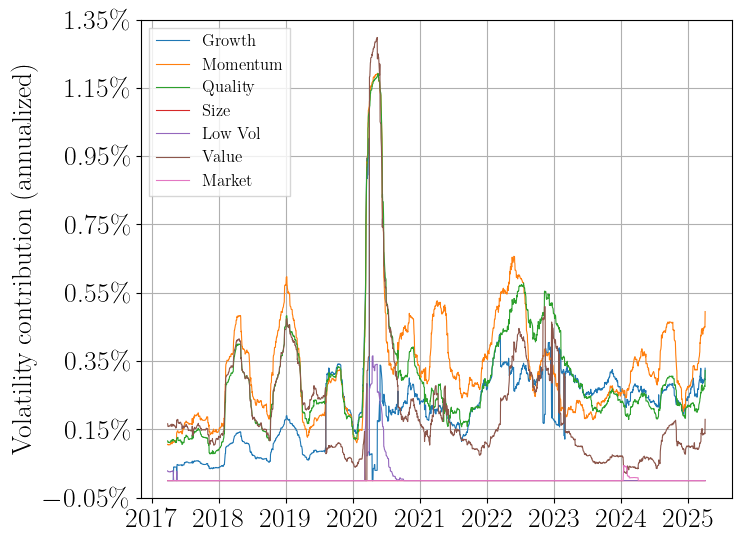

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_volatility_contributions(strategy_name,
                                  run_results,
                                  returns_df,
                                  factor_labels,
                                  window=60):          # rolling window (trading-days) for Σ
    # --- align weights & returns ----------------------------------------------
    w = run_results[strategy_name]["weights_view"]
    if "Risk-Off" not in strategy_name:
        w = w.drop(columns=["rf"], errors="ignore")
    w = w.reindex(returns_df.index).ffill().fillna(0)

    r = returns_df[w.columns].copy()

    # --- build rolling covariance cube ----------------------------------------
    # pandas stores a Panel-like MultiIndex (date, factor) x factor
    Σ = r.rolling(window).cov().dropna()

    # helper: marginal & total risk for a single date
    def _risk_decomp(t):
        s = Σ.loc[t]                         # cov-matrix at t  (DataFrame)
        w_t = w.loc[t].values               # weights vector   (np.array)
        σ_p = np.sqrt(w_t @ s.values @ w_t) # total portfolio σ
        if σ_p == 0:
            return pd.Series(0, index=s.index)

        mcr = s.values @ w_t / σ_p          # marginal contribs
        return pd.Series(w_t * mcr, index=s.index)

    # --- compute contribution series ------------------------------------------
    dates   = Σ.index.get_level_values(0).unique()
    contrib = pd.DataFrame({d: _risk_decomp(d) for d in dates}).T
    contrib = contrib.rename(columns=factor_labels)

    # use absolute values for the stacked %-share plot
    contrib_pos = contrib.abs()
    pct = contrib_pos.div(contrib_pos.sum(axis=1), axis=0)   # ← all ≥0

    total_vol = contrib_pos.sum(axis=1)  # matches the black line below

    # --- 1) %-share stacked area ----------------------------------------------
    # ax = pct.plot.area(figsize=(16,6))
    # ax.set_ylabel("Share of portfolio volatility")
    # ax.legend(loc="upper left")
    # ax.grid(True)
    # plt.show()

    # --- 2) absolute σ contributions & total σ --------------------------------
    contrib_pct = contrib * 100        # change units to %

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each column
    for col in contrib_pct.columns:
        ax.plot(contrib_pct.index, contrib_pct[col], label=col, linewidth=0.8)

    # Y-axis settings
    ax.set_ylabel(r"Volatility contribution (annualized)", fontsize=20)
    ax.set_ybound(lower=-0.05, upper=1.35)
    ax.set_yticks(np.linspace(-0.05, 1.35, 8))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))

    ax.tick_params(axis='both', labelsize=20)

    # Ticks, legend, and grid
    ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=False)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("vol_contribution.png", dpi=300) 

    plt.show()





chosen_strategy = "Dynamic Allocation (4 per cent TE)"  # or "Dynamic Allocation (1 per cent TE)" etc.
plot_volatility_contributions(chosen_strategy, run_results, test_df, factor_labels)


Strategy analysed : Base model 4% TE, half-yearly  ➜  Base model 4% TE, half-yearly
Benchmark         : Benchmark (Q-Rebalanced EW)

Allocation added value  (eq 8a) :  2.05%
Static allocation value (eq 8b) :  1.55%
Dynamic allocation      (=8a−8b):  0.49%

        Allocation 8a  Static 8b   Dynamic
Market      -0.000226  -0.000335  0.000109
iwf          0.001684   0.000870  0.000814
mtum         0.006870   0.005209  0.001661
qual         0.003384   0.002555  0.000829
size         0.008592   0.008381  0.000211
usmv         0.000219   0.000602 -0.000382
vlue        -0.000031  -0.001733  0.001702


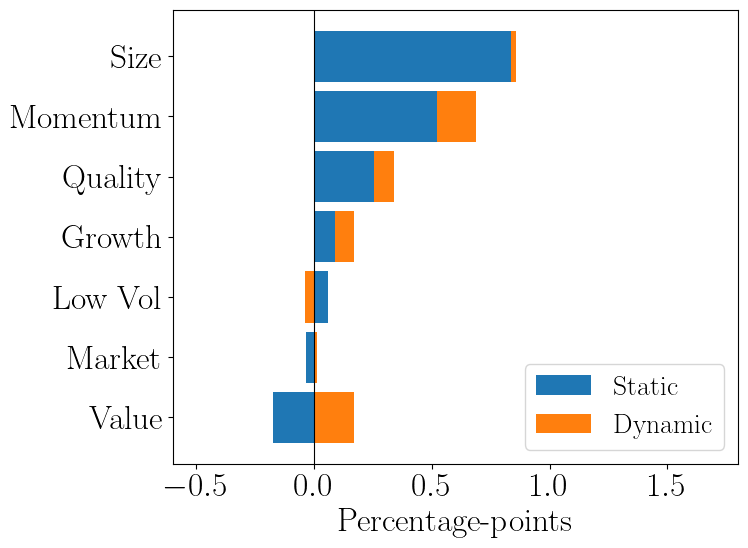

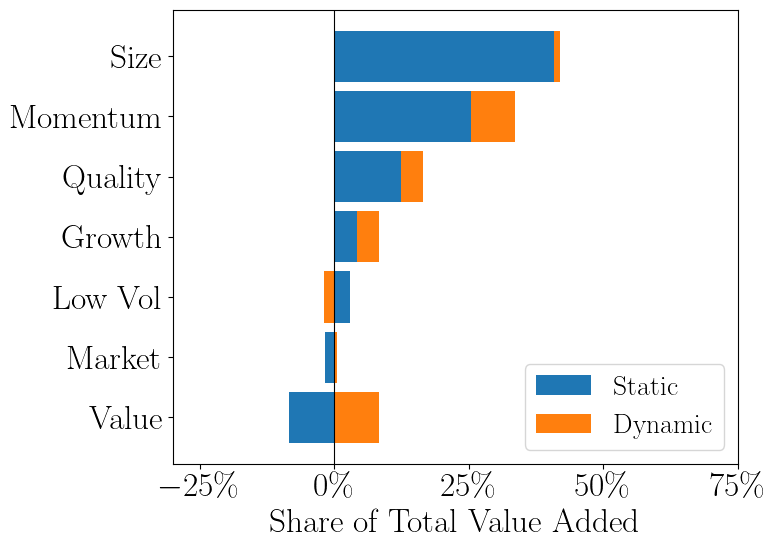

In [41]:
# ================================================================
#  Hsu–Kalesnik–Myers (2010) arithmetic attribution
#  ---------------------------------------------------------------
#  • Works on ANY strategy held in `run_results`
#  • Pick the strategy you want with the `strategy_choice` toggle
#  • Computes
#        – Allocation added value       (eq. 8a)
#        – Static  allocation added value (eq. 8b)
#        – Dynamic allocation            (= 8a − 8b)
# ================================================================
import matplotlib.ticker as mtick
# ----------------------------------------------------------------
# 2️⃣  USER TOGGLE: pick any key from the `strategy_labels` dict
# ----------------------------------------------------------------
strategy_choice  = "Base model 4% TE, half-yearly"           # <—— change at will
benchmark_choice = "Benchmark (Q-Rebalanced EW)"

strategy_label   = strategy_labels.get(strategy_choice,  strategy_choice)
benchmark_label  = strategy_labels.get(benchmark_choice, benchmark_choice)

# ----------------------------------------------------------------
# 3️⃣  Pull weights & returns  ───────────────────────────────────────────────
w_port  = run_results[strategy_label]  \
            .get("weights_actual", run_results[strategy_label]["weights_view"])
w_bench = run_results[benchmark_label] \
            .get("weights_actual", run_results[benchmark_label]["weights_view"])

# --- keep the same investable set everywhere (drop rf – or delete next 3 lines if you want to keep it) ---
cols = w_port.columns.difference(['rf'])
w_port  = w_port[cols]
w_bench = w_bench[cols]

# --- use OPENING-OF-DAY weights (shift by one day) ---
w_port  = w_port.shift()
w_bench = w_bench.shift()

# --- drop the first row that is now NaN after shifting ---
w_port  = w_port.iloc[1:]
w_bench = w_bench.iloc[1:]

# --- align return matrix exactly with the weight columns & dates ---
factor_ret = test_df[cols].loc[w_port.index]




# ----------------------------------------------------------------
# 4️⃣  HKM arithmetic allocation helpers
# ----------------------------------------------------------------
def hkm_allocation_effects(wp: pd.DataFrame,
                           wb: pd.DataFrame,
                           fr: pd.DataFrame):
    """
    Returns eq 8a (allocation) and eq 8b (static) from
    Hsu–Kalesnik–Myers (2010). Uses arithmetic means.
    """
    # --- benchmark total return each period  Rᵇ_t
    Rb_t = (wb * fr).sum(axis=1)                      # Series (T,)

    # --- eq 8a  Allocation added value
    alloc_term  = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)
    alloc_added = alloc_term.sum(axis=1).mean()

    # --- eq 8b  Static allocation added value
    avg_wdiff   = (wp - wb).mean()
    avg_excess  = fr.sub(Rb_t, axis=0).mean()
    static_added = (avg_wdiff * avg_excess).sum()

    return alloc_added, static_added

# ----------------------------------------------------------------
# 🔎 HKM arithmetic allocation – with factor-by-factor breakdown
# ----------------------------------------------------------------
def hkm_allocation_effects_breakdown(wp: pd.DataFrame,
                                     wb: pd.DataFrame,
                                     fr: pd.DataFrame):
    """
    • alloc_total   : eq 8a (scalar)
    • static_total  : eq 8b (scalar)
    • alloc_series  : eq 8a, factor-by-factor  (pd.Series, len = N)
    • static_series : eq 8b, factor-by-factor  (pd.Series, len = N)
    """
    # benchmark return each period  Rᵇ_t
    Rb_t = (wb * fr).sum(axis=1)

    # ----- eq 8a  allocation added value
    alloc_term     = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)   # T×N
    alloc_series   = alloc_term.mean()        # 1/T Σ_t (…)   – one number per factor
    alloc_total    = alloc_series.sum()       # sum_i

    # ----- eq 8b  static allocation added value
    avg_wdiff      = (wp - wb).mean()         # 1/T Σ_t (wᵖ−wᵇ)
    avg_excess     = fr.sub(Rb_t, axis=0).mean()   # 1/T Σ_t (Rᵇ_i−Rᵇ_t)
    static_series  = avg_wdiff * avg_excess   # term-by-term product
    static_total   = static_series.sum()

    return alloc_total, static_total, alloc_series, static_series


# ----------------------------------------------------------------
# 5️⃣  Run the attribution for the chosen strategy
# ----------------------------------------------------------------
alloc_val, static_val = hkm_allocation_effects(w_port, w_bench, factor_ret)
dynamic_val           = alloc_val - static_val

print(f"Strategy analysed : {strategy_choice}  ➜  {strategy_label}")
print(f"Benchmark         : {benchmark_choice}")
print()
print(f"Allocation added value  (eq 8a) : {alloc_val*252 : .2%}")
print(f"Static allocation value (eq 8b) : {static_val*252: .2%}")
print(f"Dynamic allocation      (=8a−8b): {dynamic_val*252: .2%}")

# ----------------------------------------------------------------
# 5️⃣  Run it
# ----------------------------------------------------------------
alloc_tot, static_tot, alloc_ser, static_ser = (
    hkm_allocation_effects_breakdown(w_port, w_bench, factor_ret)
)
dynamic_ser = alloc_ser - static_ser            # factor-level dynamic
dynamic_tot = alloc_tot - static_tot            # already had this

# OPTIONAL: annualise (if inputs are daily)
annualise = 252
alloc_ser_yr   = alloc_ser   * annualise
static_ser_yr  = static_ser  * annualise
dynamic_ser_yr = dynamic_ser * annualise

breakdown = pd.DataFrame({
    "Allocation 8a": alloc_ser_yr,
    "Static 8b":    static_ser_yr,
    "Dynamic":      dynamic_ser_yr
})

print()
print(breakdown)

plt.rcParams.update({'font.size': 20})

# ---------------------------------------------------------------
# Factor label mapping
# ---------------------------------------------------------------
factor_labels_attrib = {
    "iwf":  "Growth",
    "mtum": "Momentum",
    "qual": "Quality",
    "size": "Size",
    "usmv": "Low Vol",
    "vlue": "Value",
    "Market": "Market",
    "rf":     "Risk‑free"
}

# ---------------------------------------------------------------
# Build DataFrame with factor contributions (annual %‑points)
# ---------------------------------------------------------------
df_attrib = pd.DataFrame({
    "Static": static_ser_yr * 100,
    "Dynamic":     dynamic_ser_yr * 100,
})

# Apply nicer factor names (leave unmapped items untouched)
df_attrib.index = df_attrib.index.map(lambda x: factor_labels_attrib.get(x, x))

df_attrib = df_attrib.drop(index="rf", errors="ignore")

# Sort as desired (e.g. by Dynamic)
df_attrib = df_attrib.sort_values("Static", ascending=True)

# ---------------------------------------------------------------
# Horizontal bar plot
# ---------------------------------------------------------------
# set base font size
static  = df_attrib["Static"].values
dynamic = df_attrib["Dynamic"].values

# for each row:
#  • if static and dynamic have the same sign, start at static
#  • otherwise start at zero
left_dyn = np.where(np.sign(static)==np.sign(dynamic), static, 0)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 24})
bar_w = 0.85
y     = np.arange(len(df_attrib))

ax.barh(y, static,  bar_w, label="Static")
ax.barh(y, dynamic, bar_w, left=left_dyn, label="Dynamic")

ax.set_yticks(y)
ax.set_yticklabels(df_attrib.index, fontsize=24)
ax.set_xlabel("Percentage-points", fontsize=24)
ax.axvline(0, color="black", linewidth=0.8)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20, loc="lower right")
ax.margins(x=0.05)
ax.set_xbound(-0.6, 1.8)
plt.tight_layout()
plt.show()

# plt.rcParams.update({'font.size': 20})

# ax = factor_contrib[["Static Allocation", "Dynamic Allocation"]].plot.barh(
#     stacked=True, figsize=(8, 6), width=0.85)

# ax.set_xlabel("Percentage-points", fontsize=20)          # inherits 20 pt
# ax.axvline(0, color="black", linewidth=0.8)

# # keep ticks and title at 20 pt
# ax.tick_params(axis='both', labelsize=20)
# ax.set_title(ax.get_title(), fontsize=20)

# # legend only 12 pt
# ax.legend(fontsize=18)

# plt.tight_layout()
# plt.show()

# 1. Compute each factor’s total contribution (static + dynamic)
total_contrib = df_attrib["Static"] + df_attrib["Dynamic"]

# 2. Compute each piece as % of the sum of total contributions
total_value = total_contrib.sum()
df_share = pd.DataFrame({
    "Static %":  df_attrib["Static"]  / df_attrib.sum().sum() * 100,
    "Dynamic %": df_attrib["Dynamic"] / df_attrib.sum().sum() * 100
})

static  = df_share["Static %"].values
dynamic = df_share["Dynamic %"].values
left_dyn = np.where(np.sign(static)==np.sign(dynamic), static, 0)

y = np.arange(len(df_share))
fig, ax = plt.subplots(figsize=(8,6))

# static first
ax.barh(y, static, 0.85, label="Static")
# dynamic second, but only offset by static when same‐sign
ax.barh(y, dynamic, 0.85, left=left_dyn, label="Dynamic")

ax.set_yticks(y)
ax.set_yticklabels(df_attrib.index, fontsize=24)
ax.set_xlabel("Share of Total Value Added", fontsize=24)
ax.axvline(0, color="black", linewidth=0.8)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20, loc="lower right")
ax.margins(x=0.05)
ax.set_xbound(-30, 75)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.tight_layout()
plt.show()

In [11]:
# Yearly buy-hold factor performances
def calculate_yearly_factor_metrics(returns_df, start_date='2017-01-01', risk_free_col='rf'):
    import pandas as pd, numpy as np

    returns = returns_df.copy().loc[start_date:]
    rf = returns[risk_free_col]
    excess = returns.drop(columns=[risk_free_col]).sub(rf, axis=0)
    excess['year'] = excess.index.year
    grp = excess.groupby('year')
    
    # yearly metrics
    er = pd.DataFrame({y: g.drop(columns='year').mean() * 252 for y, g in grp}).T
    ev = pd.DataFrame({y: g.drop(columns='year').std() * np.sqrt(252) for y, g in grp}).T
    sr = er.div(ev)
    
    # total-period metrics
    all_ret = excess.drop(columns='year')
    total_er = all_ret.mean() * 252
    total_ev = all_ret.std() * np.sqrt(252)
    total_sr = total_er / total_ev
    
    # append Total row
    for df, total in [(er, total_er), (ev, total_ev), (sr, total_sr)]:
        df.loc['Total'] = total
    
    return {
        'excess_return': er,
        'excess_vol':     ev,
        'sharpe_ratio':   sr
    }

# then rename columns & display as before
yearly_metrics = calculate_yearly_factor_metrics(etf_df)
for m in yearly_metrics:
    yearly_metrics[m] = yearly_metrics[m].rename(columns=factor_labels)

print("Yearly Factor Excess Returns:")
display(yearly_metrics['excess_return'].style.format("{:.4f}"))

print("\nYearly Factor Excess Volatility:")
display(yearly_metrics['excess_vol'].style.format("{:.4f}"))

print("\nYearly Factor Sharpe Ratios:")
display(yearly_metrics['sharpe_ratio'].style.format("{:.4f}"))


Yearly Factor Excess Returns:


,Market,VLUE (Value factor),SIZE (Size factor),MTUM (Momentum factor),QUAL (Quality factor),USMV (Low-volatility factor),IWF (Growth factor)
2017,0.1672,0.1701,0.1495,0.3034,0.1756,0.1479,0.2446
2018,-0.0787,-0.1472,-0.0983,-0.0260,-0.0830,-0.0176,-0.0285
2019,0.2378,0.2048,0.2287,0.2157,0.2645,0.2096,0.2872
2020,0.2281,0.0409,0.1956,0.3088,0.1944,0.0796,0.3732
2021,0.2244,0.2425,0.2199,0.1423,0.2338,0.1801,0.2504
2022,-0.2198,-0.1773,-0.1786,-0.2089,-0.2309,-0.1181,-0.3292
2023,0.1766,0.0663,0.1116,0.0318,0.2173,0.0338,0.3126
2024,0.1588,0.0027,0.0742,0.2445,0.1489,0.0842,0.2456
2025,-0.6713,-0.4826,-0.5702,-0.5116,-0.6153,-0.1753,-0.8646
Total,0.0872,0.0335,0.0672,0.1066,0.0921,0.0671,0.1370



Yearly Factor Excess Volatility:


,Market,VLUE (Value factor),SIZE (Size factor),MTUM (Momentum factor),QUAL (Quality factor),USMV (Low-volatility factor),IWF (Growth factor)
2017,0.0706,0.0840,0.0643,0.0833,0.0646,0.0548,0.0754
2018,0.1695,0.1744,0.1484,0.2145,0.1700,0.1320,0.1975
2019,0.1262,0.1475,0.1290,0.1280,0.1298,0.0956,0.1431
2020,0.3472,0.3907,0.3643,0.3570,0.3423,0.3136,0.3533
2021,0.1365,0.1537,0.1386,0.2107,0.1355,0.1038,0.1697
2022,0.2489,0.2306,0.2457,0.2510,0.2590,0.1834,0.3057
2023,0.1356,0.1470,0.1520,0.1333,0.1379,0.0981,0.1594
2024,0.1298,0.1334,0.1228,0.1914,0.1298,0.0866,0.1739
2025,0.2202,0.2081,0.2018,0.2953,0.2003,0.1561,0.2728
Total,0.1903,0.2028,0.1919,0.2150,0.1904,0.1540,0.2169



Yearly Factor Sharpe Ratios:


,Market,VLUE (Value factor),SIZE (Size factor),MTUM (Momentum factor),QUAL (Quality factor),USMV (Low-volatility factor),IWF (Growth factor)
2017,2.3680,2.0260,2.3236,3.6407,2.7202,2.6989,3.2434
2018,-0.4642,-0.8437,-0.6620,-0.1211,-0.4884,-0.1336,-0.1445
2019,1.8845,1.3887,1.7730,1.6848,2.0369,2.1929,2.0074
2020,0.6569,0.1046,0.5370,0.8650,0.5678,0.2538,1.0565
2021,1.6436,1.5781,1.5864,0.6754,1.7252,1.7341,1.4756
2022,-0.8832,-0.7686,-0.7269,-0.8324,-0.8917,-0.6440,-1.0769
2023,1.3027,0.4508,0.7341,0.2389,1.5752,0.3442,1.9616
2024,1.2236,0.0199,0.6042,1.2773,1.1472,0.9725,1.4125
2025,-3.0487,-2.3188,-2.8257,-1.7325,-3.0727,-1.1234,-3.1695
Total,0.4582,0.1653,0.3500,0.4961,0.4837,0.4361,0.6317


In [ ]:
#Statistical test for difference in Sharpe ratios

def _moments(x):
    μ      = x.mean()
    σ      = x.std(ddof=0)              # population std. dev.
    m3     = ((x-μ)**3).mean()          # third central moment
    m4     = ((x-μ)**4).mean()          # fourth central moment
    γ3, γ4 = m3/σ**3 , m4/σ**4          # skew- & kurtosis‐coefficients
    return μ, σ, γ3, γ4

def _var_sr(μ, σ, γ3, γ4, SR, T):
    return ( (γ4-1)/4  - SR*γ3 + 0.5*SR**2 ) / T

def _cross_moments(a, b):
    """
    Unbiased h-statistics for μ22, μ12, μ21  (Opdyke 2006 App. C)
    """
    n   = len(a)
    da  = a - a.mean()
    db  = b - b.mean()

    s1a = da.sum();          s1b = db.sum()
    s2a = (da**2).sum();     s2b = (db**2).sum()
    s11 = (da*db).sum()

    μ22 = (n*s2a*s2b - (n+1)*s2a*s2b + 2*s11**2) / (n*(n-1)*(n-2)*(n-3))
    μ12 = (n*(da*db**2).sum() - 2*s1a*s2b - s1b*s11) / (n*(n-1)*(n-2))
    μ21 = (n*(db*da**2).sum() - 2*s1b*s2a - s1a*s11) / (n*(n-1)*(n-2))
    return μ22, μ12, μ21

def opdyke_z(a, b, rf=0.0, periods=252):
    # excess returns  – drop NaNs first
    ra, rb = np.asarray(a) - rf, np.asarray(b) - rf
    mask   = ~np.isnan(ra) & ~np.isnan(rb)
    ra, rb = ra[mask], rb[mask]
    T      = len(ra)

    # moments & SRs
    μa, σa, γ3a, γ4a = _moments(ra)
    μb, σb, γ3b, γ4b = _moments(rb)
    SRa, SRb        = μa/σa, μb/σb

    # variances
    Va = _var_sr(μa, σa, γ3a, γ4a, SRa, T)
    Vb = _var_sr(μb, σb, γ3b, γ4b, SRb, T)

    # covariance part
    μ22, μ12, μ21   = _cross_moments(ra, rb)
    rho             = np.corrcoef(ra, rb)[0,1]
    # --- just replace your Cab assignment ---
    Cab = ((μ22/(4*σa**2*σb**2)
            - SRa*μ12/(2*σa*σb**2)
            - SRb*μ21/(2*σa**2*σb)
            + 0.5*rho*SRa*SRb)      
            / T)                      

    # test statistic
    denom = Va + Vb - 2*Cab          # Var(SRa−SRb)
    if denom <= 0:                   # finite-sample collapse – test is undefined
        return SRa*np.sqrt(periods), SRb*np.sqrt(periods), np.nan, np.nan
    z  = (SRa - SRb) / np.sqrt(denom)
    p  = 2*(1 - stats.norm.cdf(abs(z)))
    return SRa*np.sqrt(periods), SRb*np.sqrt(periods), z, p

bench = ew_rets
for name, res in run_results.items():
    sr_a, sr_b, z, p = opdyke_z(res["returns"], bench)
    print(f"{name:30s} ΔSR={sr_a-sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")


Dynamic Allocation (4 per cent TE) ΔSR=+0.077, z=+0.08, p=0.938
Dynamic Allocation (3 per cent TE) ΔSR=+0.071, z=+0.07, p=0.944
Dynamic Allocation (2 per cent TE) ΔSR=+0.066, z=+0.06, p=0.949
Dynamic Allocation (1 per cent TE) ΔSR=+0.075, z=+0.07, p=0.943
Dynamic Long-Short Allocation (4 per cent TE) ΔSR=+0.063, z=+0.06, p=0.951
Dynamic Long-Short Allocation (3 per cent TE) ΔSR=+0.073, z=+0.07, p=0.944
Dynamic Long-Short Allocation (2 per cent TE) ΔSR=+0.085, z=+0.08, p=0.935
Dynamic Long-Short Allocation (1 per cent TE) ΔSR=+0.093, z=+0.09, p=0.929
Dynamic Allocation with Risk-Off (4 per cent TE) ΔSR=+0.325, z=+0.37, p=0.708
Dynamic Allocation with Risk-Off (3 per cent TE) ΔSR=+0.340, z=+0.39, p=0.696
Dynamic Allocation with Risk-Off (2 per cent TE) ΔSR=+0.360, z=+0.41, p=0.681
Dynamic Allocation with Risk-Off (1 per cent TE) ΔSR=+0.405, z=+0.46, p=0.645
Benchmark (Q-Rebalanced EW)    ΔSR=+0.000, z=+0.00, p=1.000
Benchmark (Market Buy-Hold)    ΔSR=+0.003, z=+0.00, p=0.998


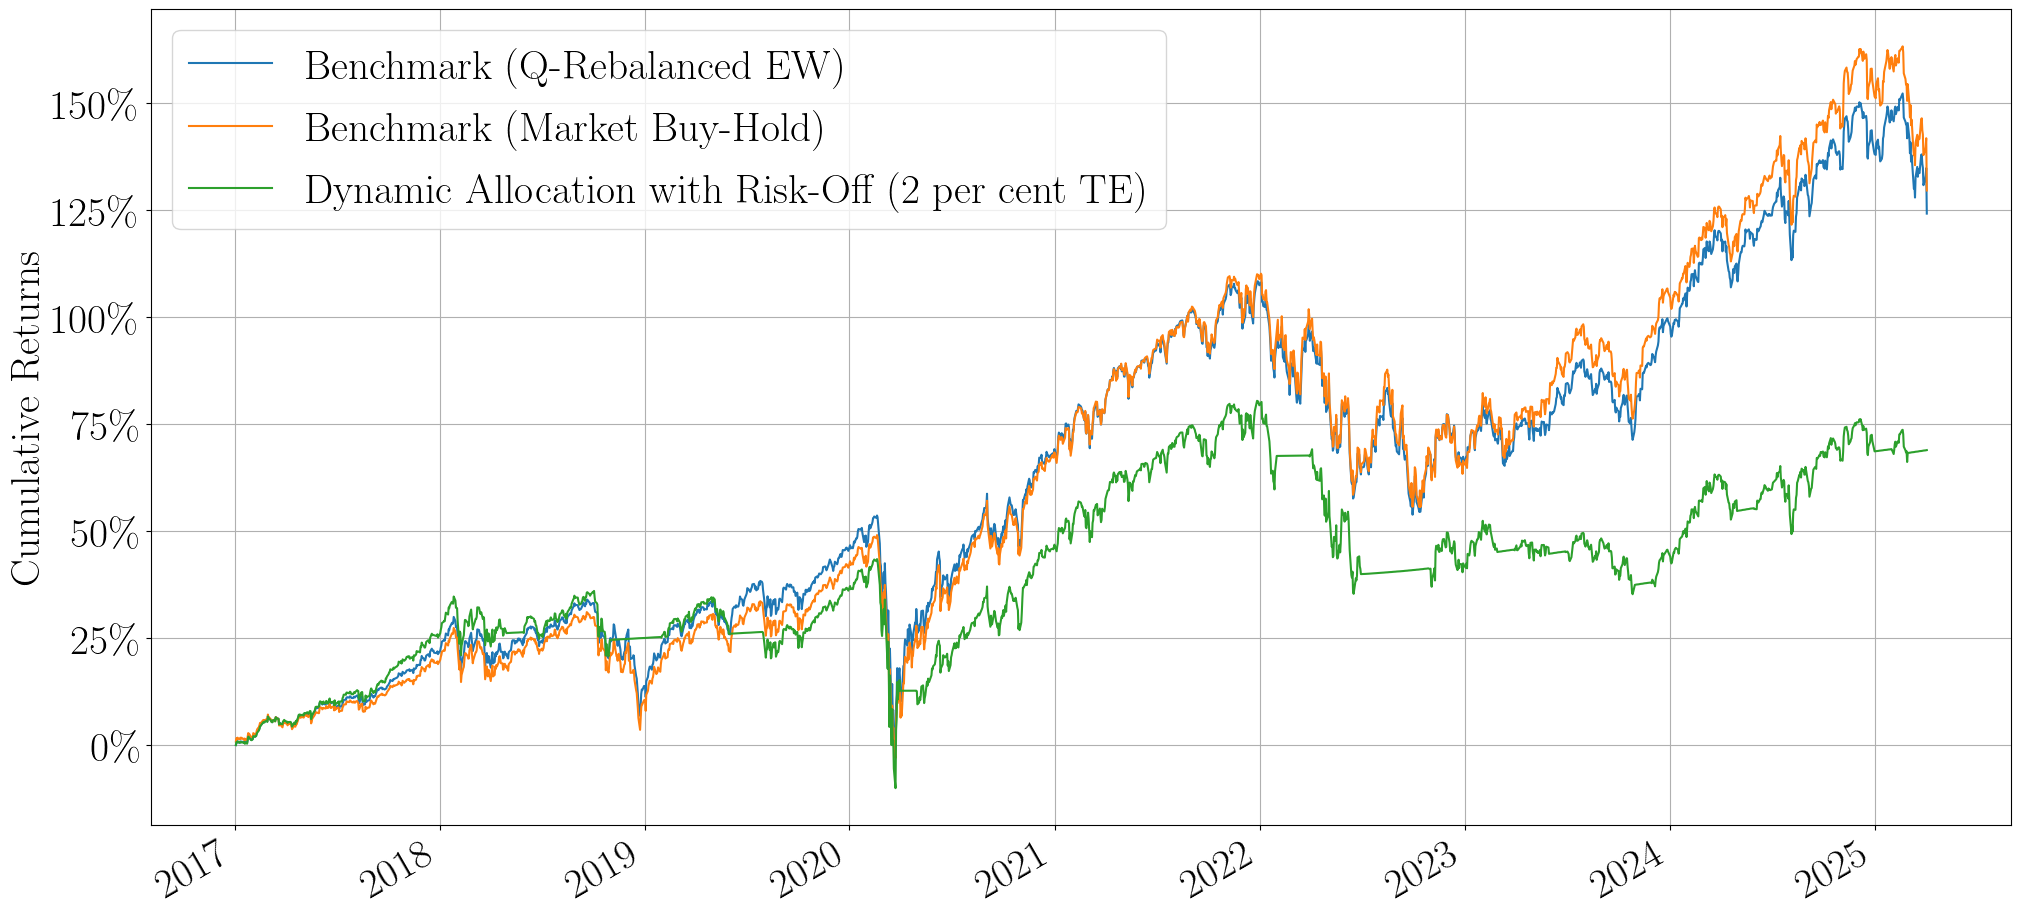

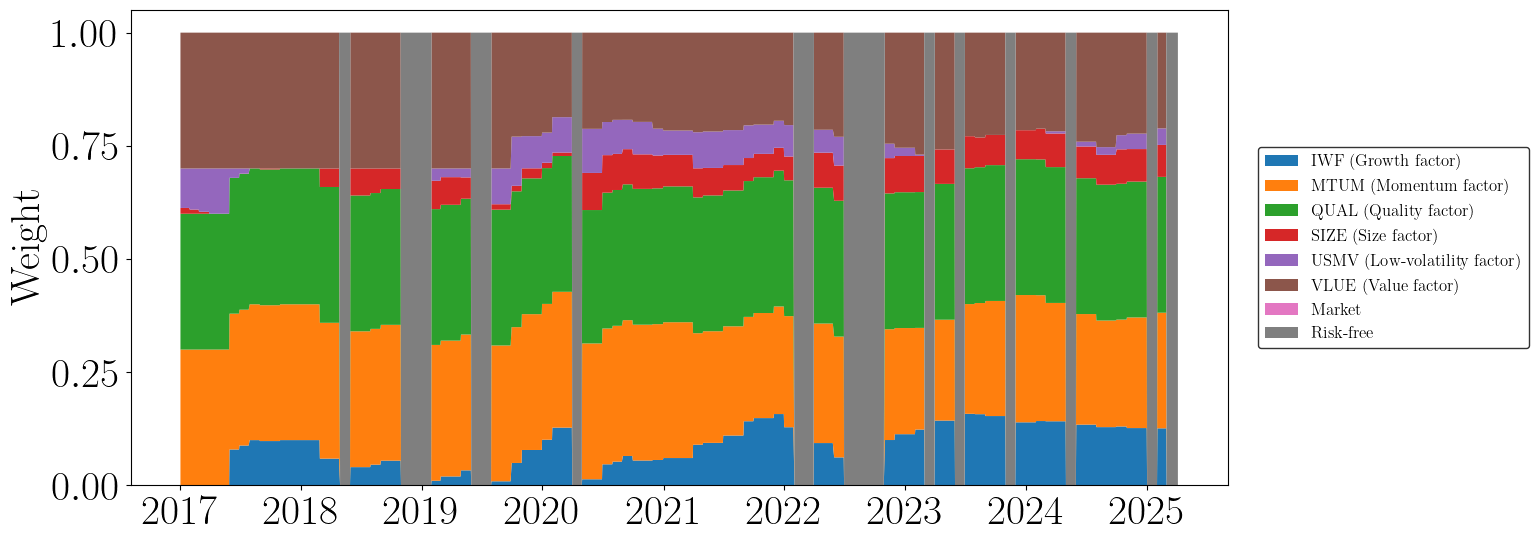

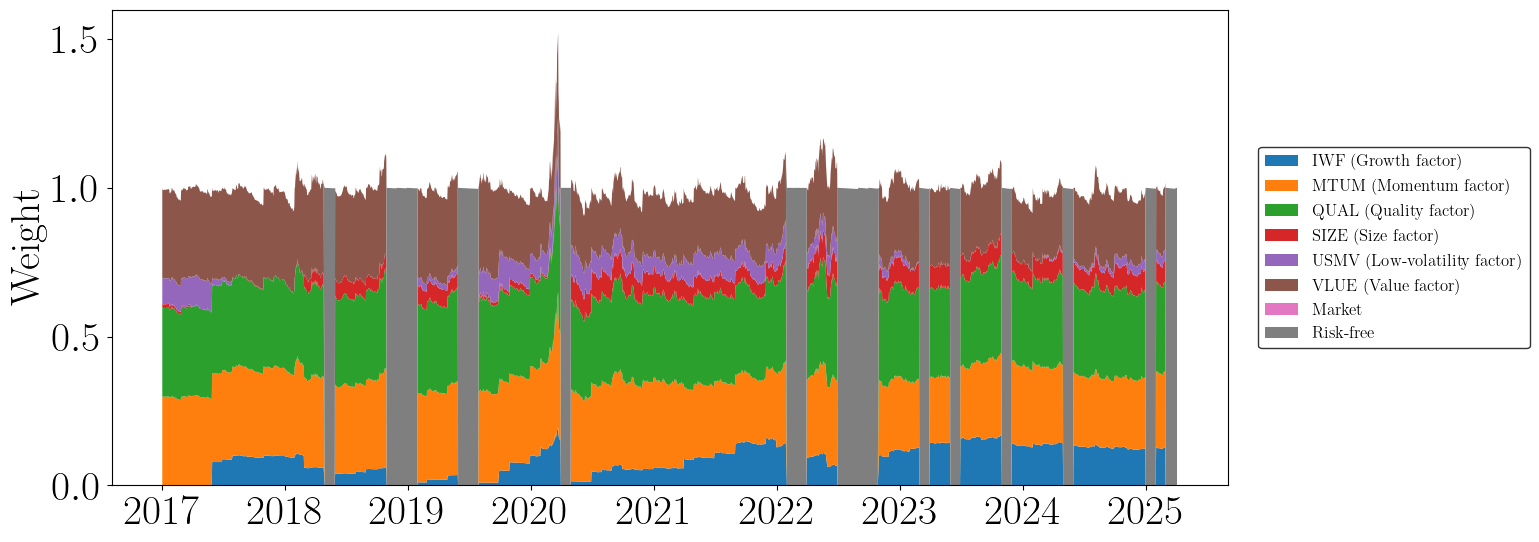

In [21]:
# Plots for save
_update(
    compare=list(cmp.value),      # the configs you ticked in “Compare”
    weights_cfg=wgt.value,        # the config chosen in “Weights”
    sign_filter=sign.value        # 'both' / 'pos' / 'neg' from the toggle
)

                                               CAPM beta
Strategy                                                
Dynamic Allocation (4 per cent TE)                 1.016
Dynamic Long-Short Allocation (4 per cent TE)      1.041
Dynamic Allocation (1 per cent TE)                 0.924
Dynamic Long-Short Allocation (1 per cent TE)      0.916


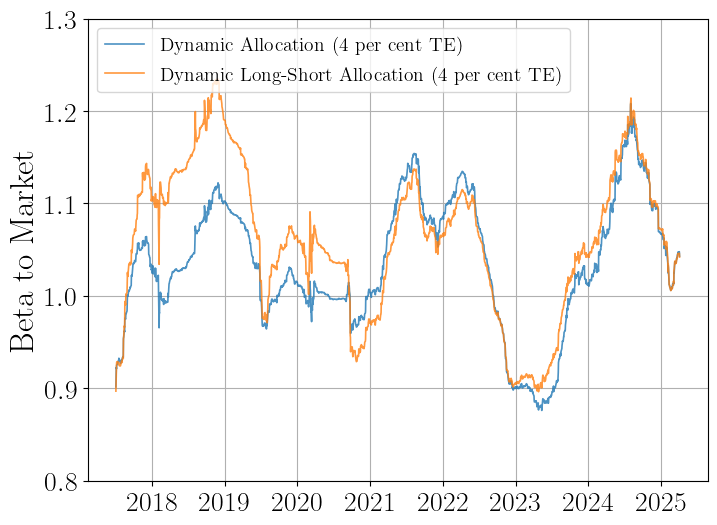

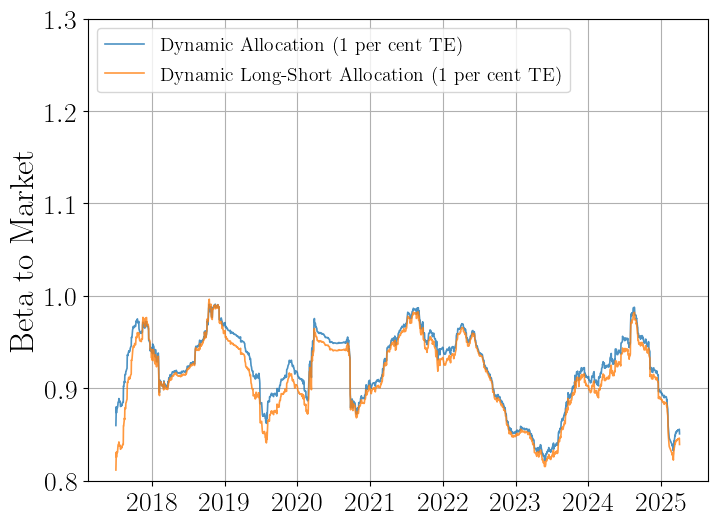

In [192]:
# ------------------------------------------------------------
# QUICK CHECK — Is the L/S book really beta-neutral?
# ------------------------------------------------------------
#
# 1)  Pick the strategies you want to test.
#     (Long-only vs. corresponding long-short at the same TE.)
# 2)  Regress each portfolio’s *excess* daily returns on the
#     market’s *excess* daily returns → CAPM beta.
# 3)  Print both the full-sample beta and a 6-month rolling beta
#     so you can see whether neutrality is stable through time.
#
# Assumes `run_results` (your strategies) and `etf_df["Market"]`
# are already in memory, exactly as in your notebook.
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def capm_beta(port_ret, mkt_ret):
    """OLS beta of portfolio excess return vs. market excess return."""
    y, x = port_ret.align(mkt_ret, join="inner")
    x = sm.add_constant(x)           # adds 'const' plus an unnamed column
    model = sm.OLS(y, x, missing="drop").fit()
    # beta is the coefficient after the intercept, whatever it's called
    return model.params.drop("const").iloc[0]



# -------- pick strategies ---------------------------------------
pairs = [
    ("Dynamic Allocation (4 per cent TE)",  "Dynamic Long-Short Allocation (4 per cent TE)"),
    ("Dynamic Allocation (1 per cent TE)",  "Dynamic Long-Short Allocation (1 per cent TE)"),
    # ("Base model 1% TE",  "L/S 1% TE"),
]

mkt = etf_df["Market"].loc[full_idx] - etf_df["rf"].loc[full_idx]   # excess market return

results = []

for long_only, long_short in pairs:
    for lab in (long_only, long_short):
        r  = run_results[lab]["returns"]       # daily total return
        rex = r - etf_df["rf"].reindex(r.index)  # excess return
        beta = capm_beta(rex, mkt)
        results.append({"Strategy": lab, "CAPM beta": beta})

df_beta = pd.DataFrame(results).set_index("Strategy")
print(df_beta.round(3))

# -------- optional: rolling beta plot ---------------------------
window = 126     # ~6 months of trading days

for long_only, long_short in pairs:
    fig, ax = plt.subplots(figsize=(8, 6))

    for lab, color in [(long_only, "tab:blue"), (long_short, "tab:orange")]:
        r = run_results[lab]["returns"]
        rex = r - etf_df["rf"].reindex(r.index)
        roll_beta = (
            rex.rolling(window)
               .cov(mkt)
               / mkt.rolling(window).var()
        )
        ax.plot(roll_beta.index, roll_beta.values, label=lab, color=color, alpha=0.8, lw=1.2)

    ax.axhline(0, color="grey", ls="--", linewidth=1.5)
    ax.set_ylabel("Beta to Market", fontsize=24)
    ax.set_xlabel("", fontsize=20)
    ax.set_ylim(0.8, 1.3)
    
    ax.legend(loc="upper left", fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=20)

    plt.show()



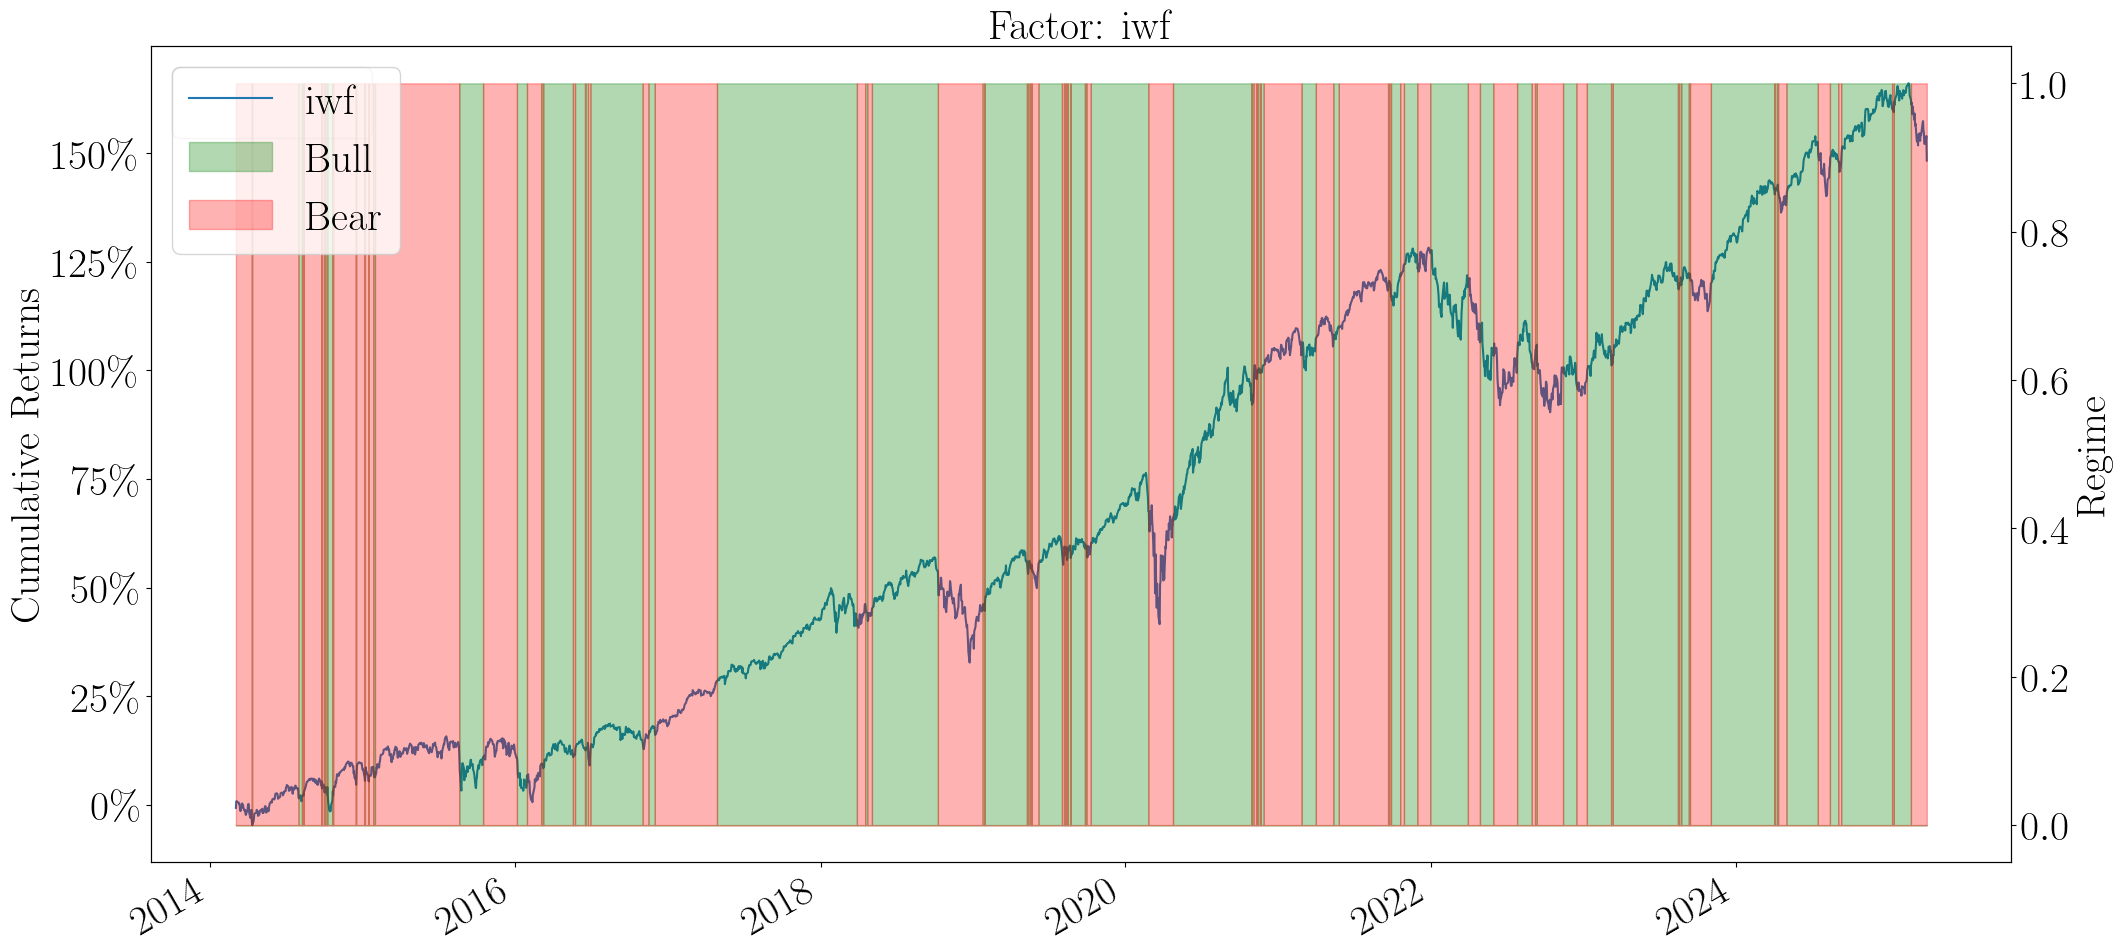

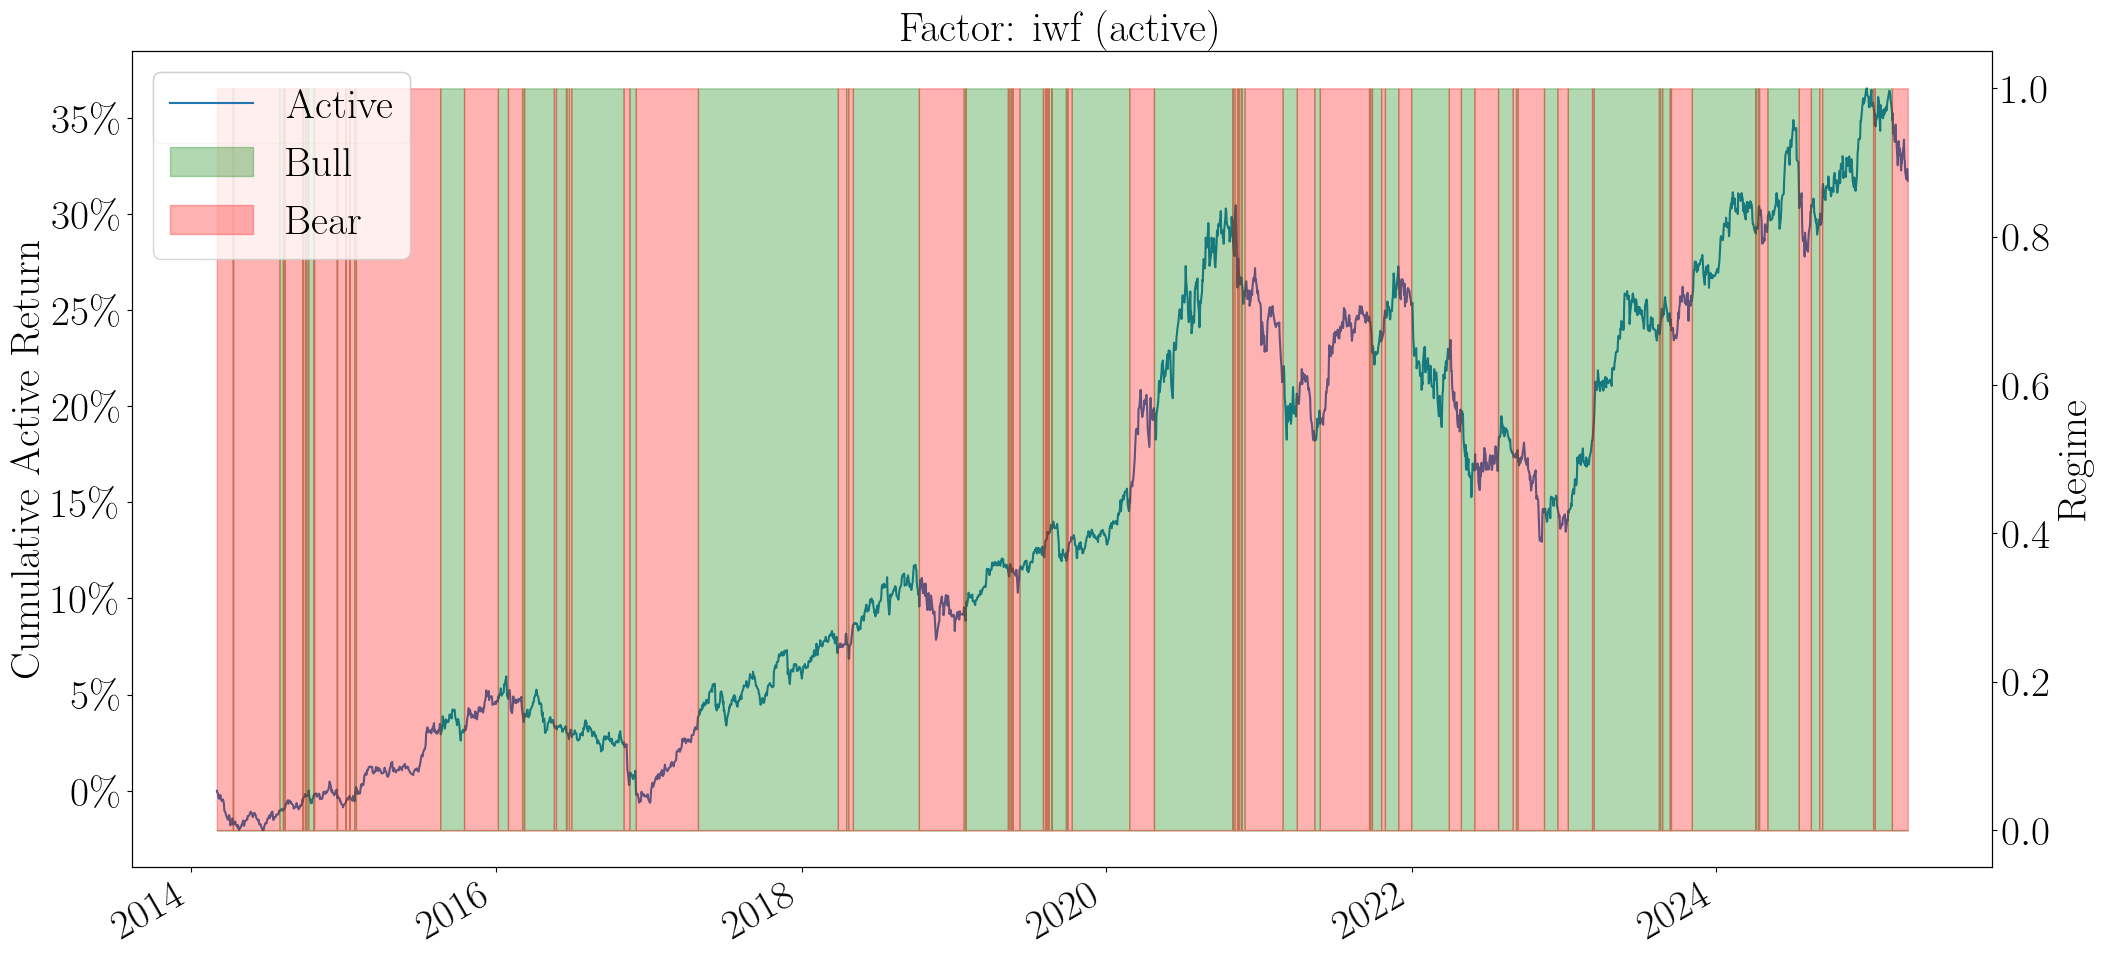

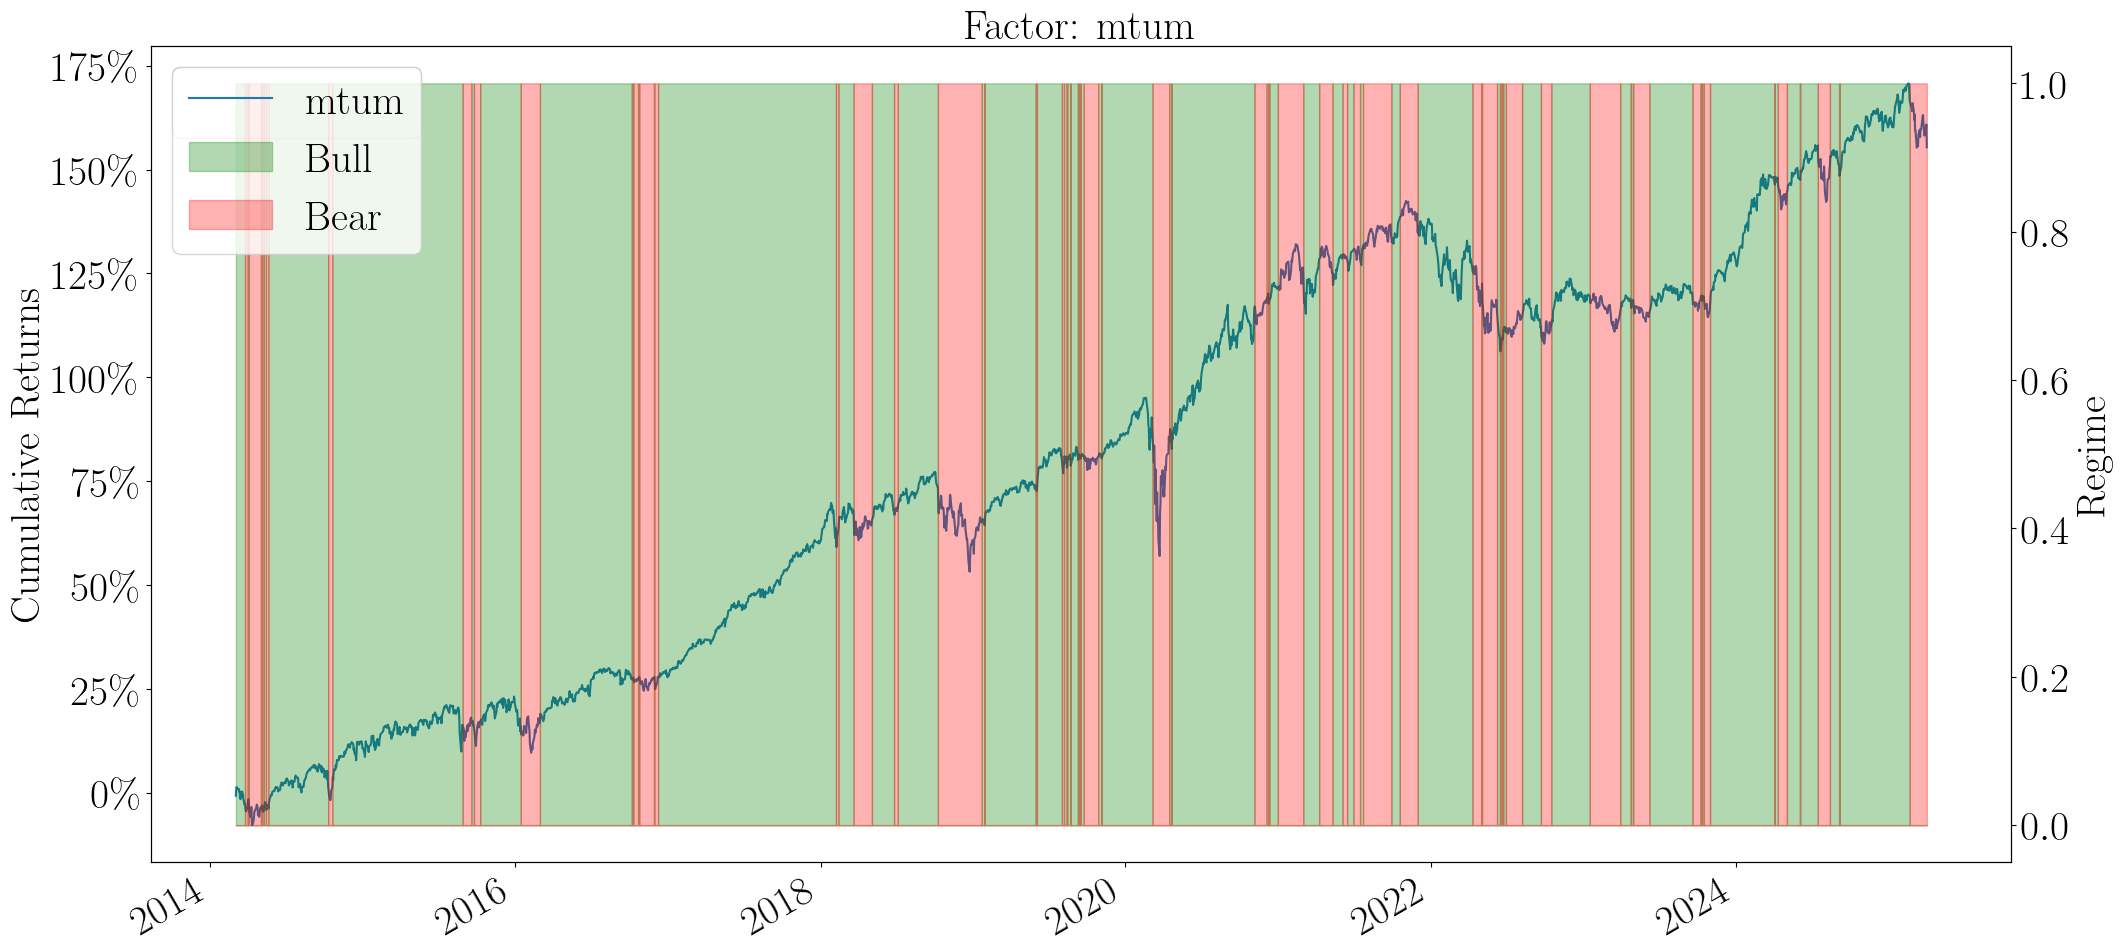

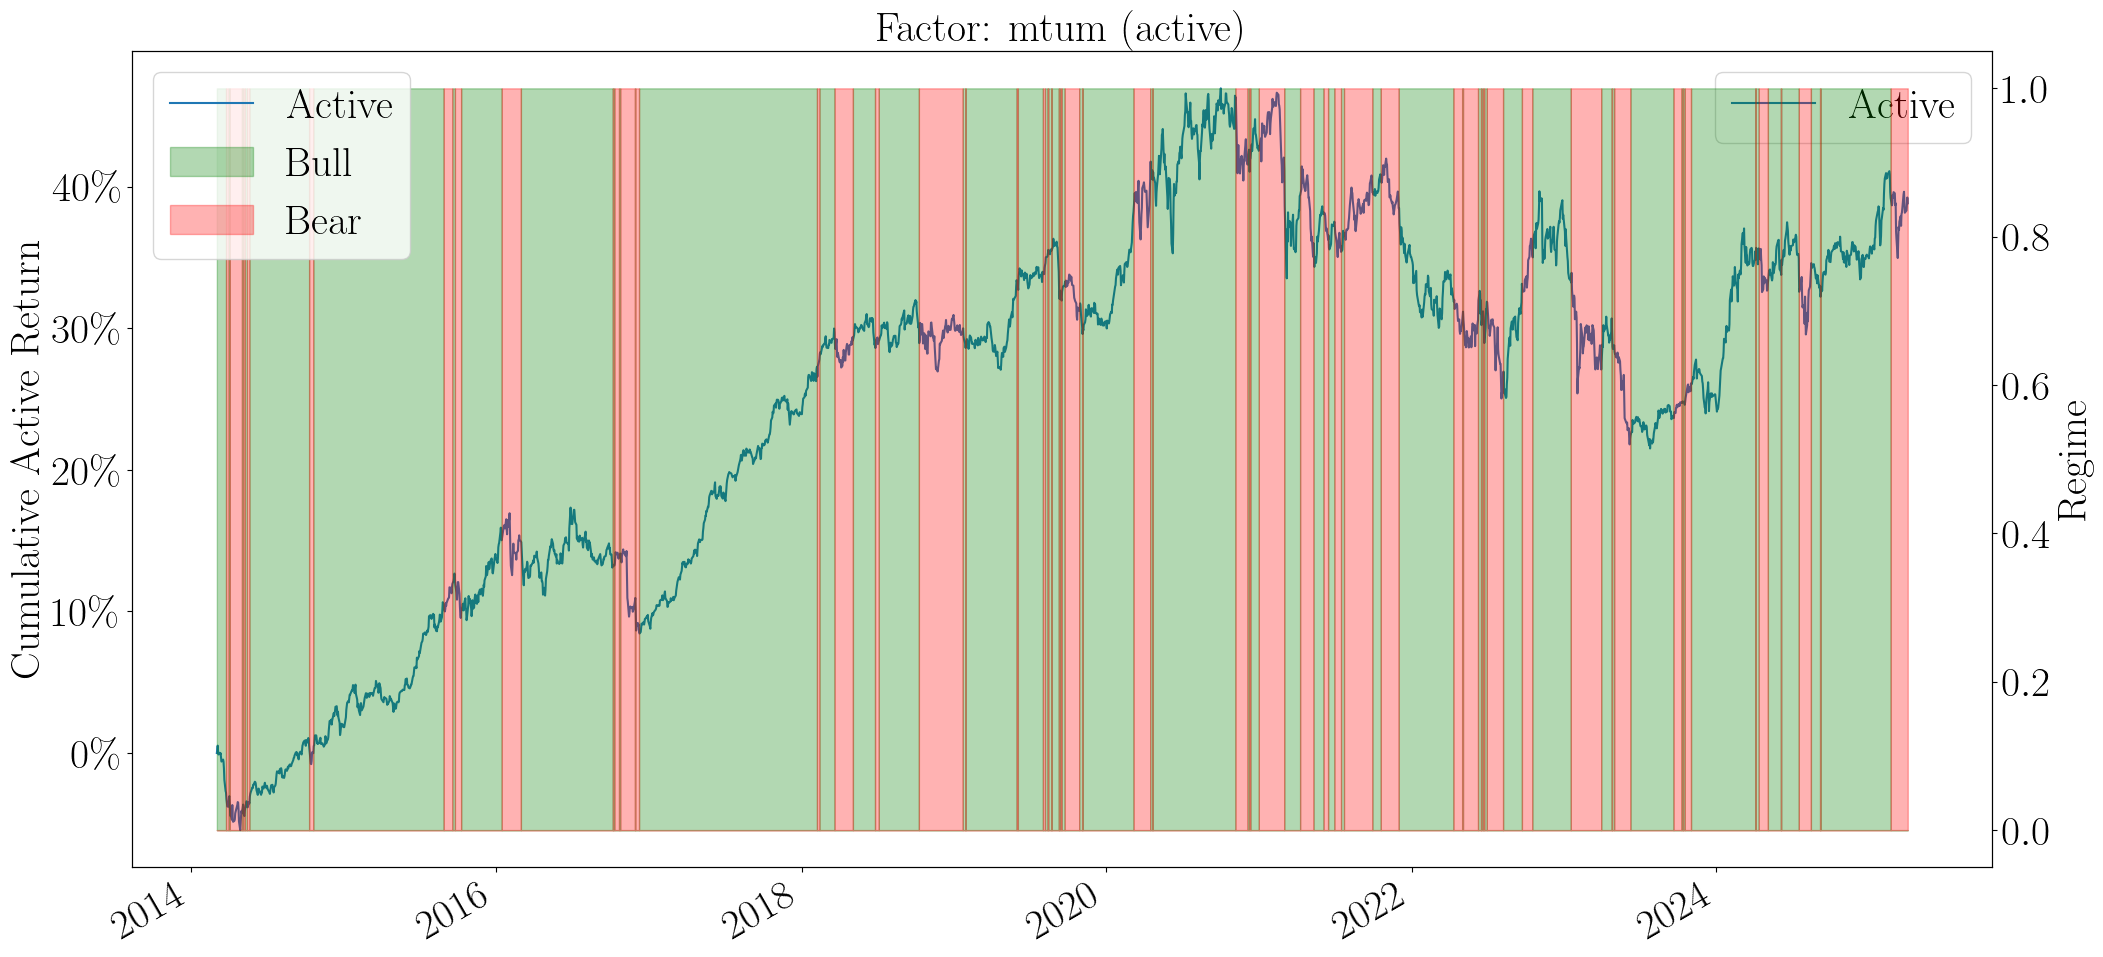

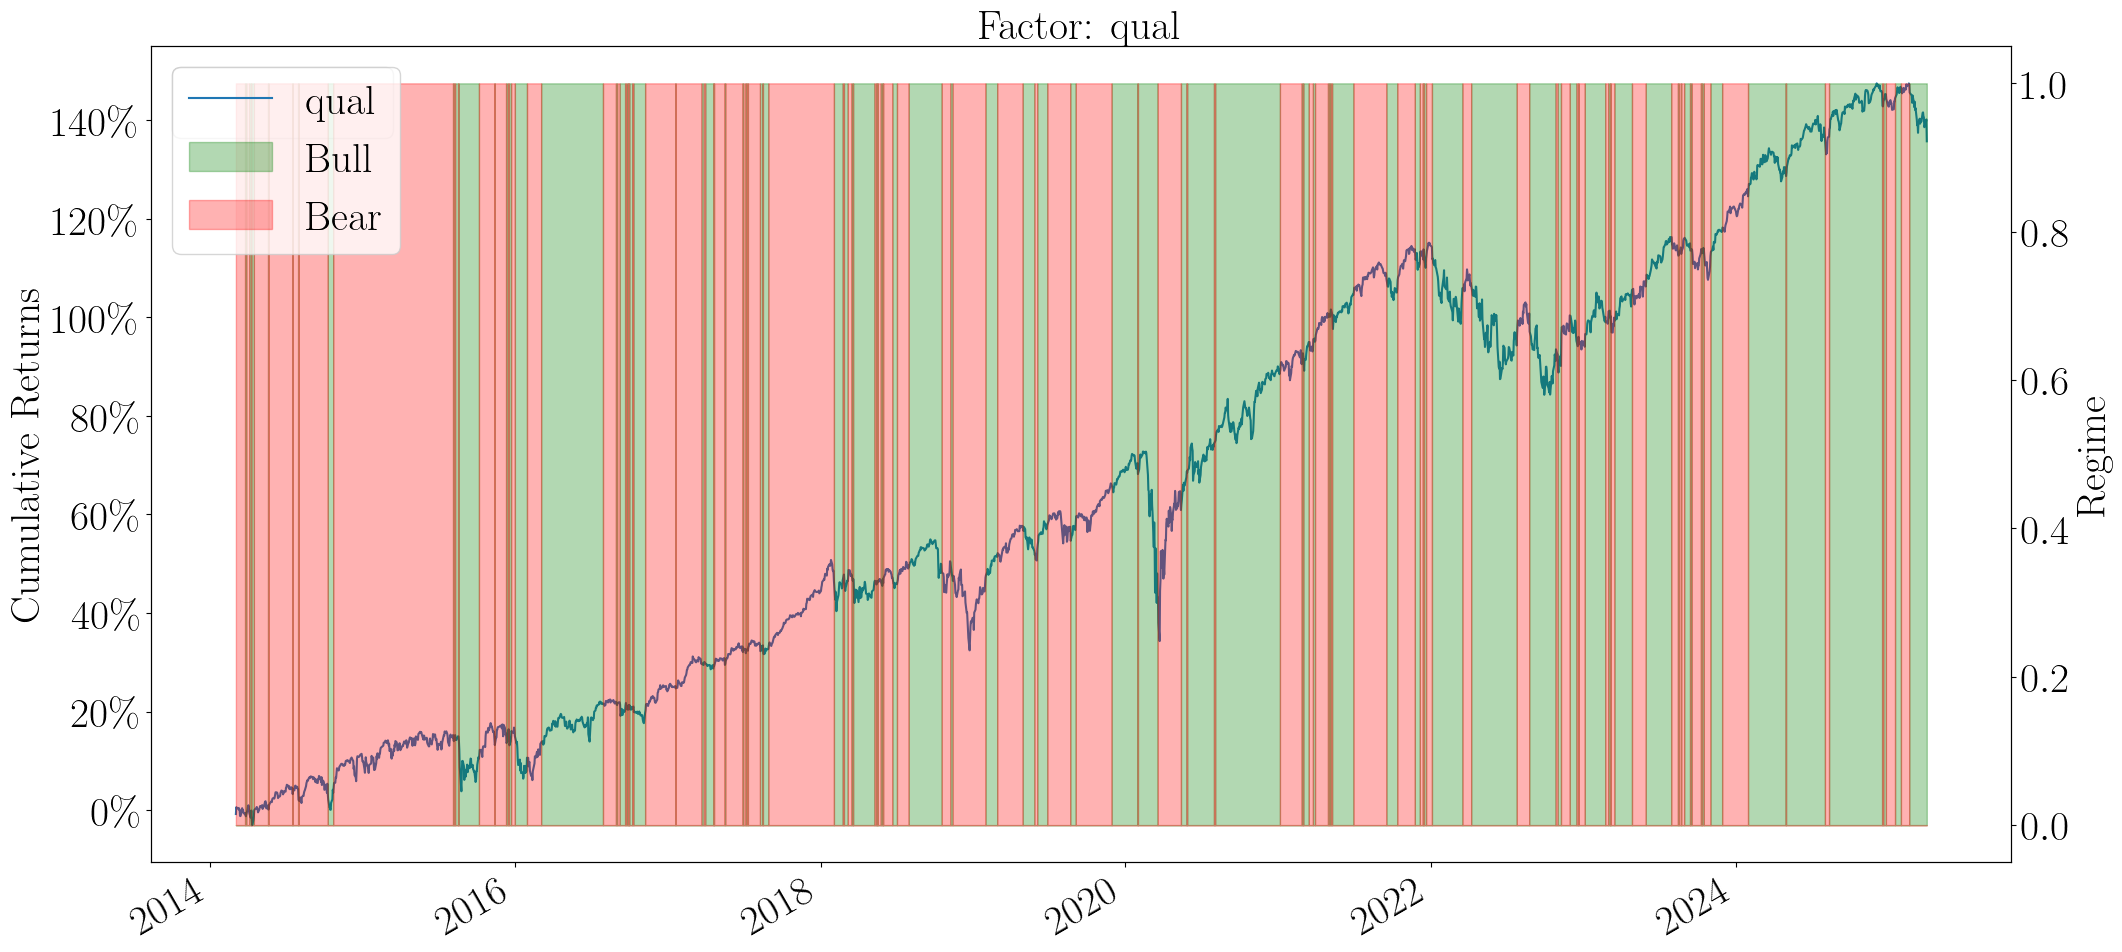

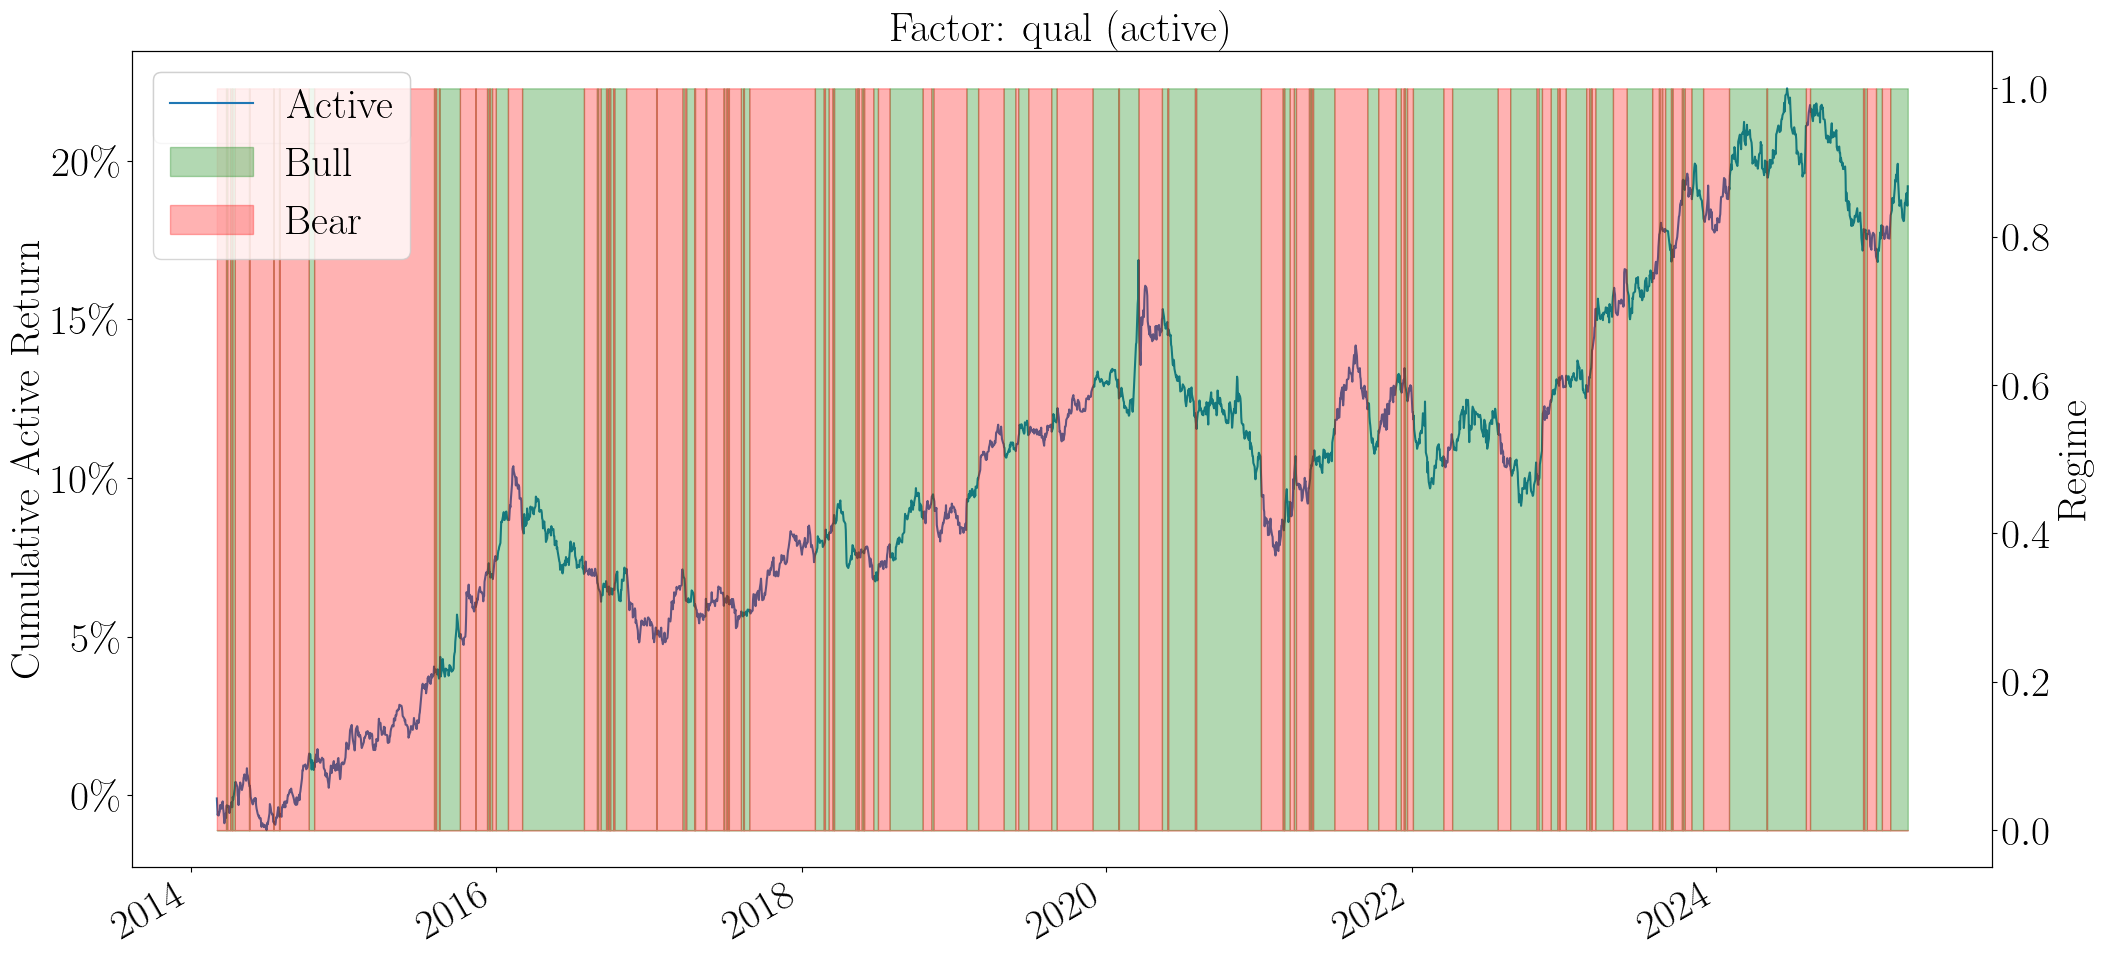

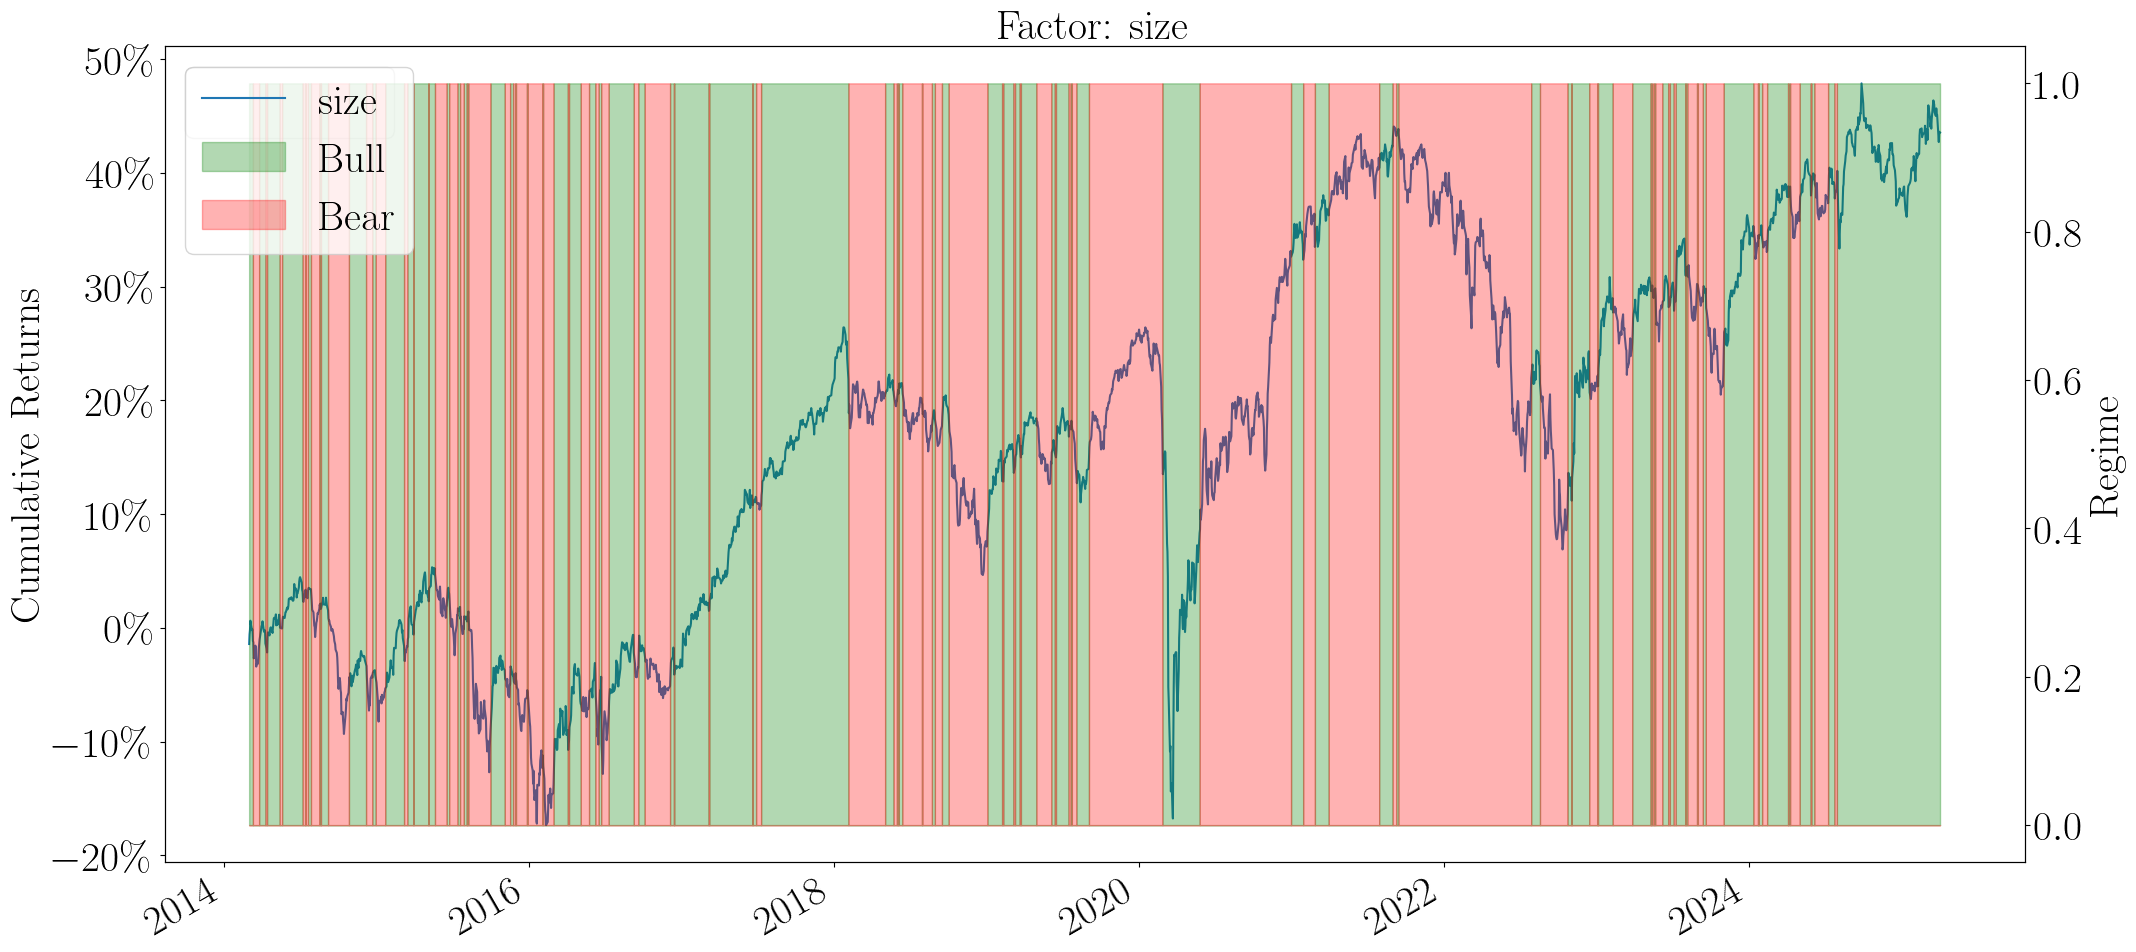

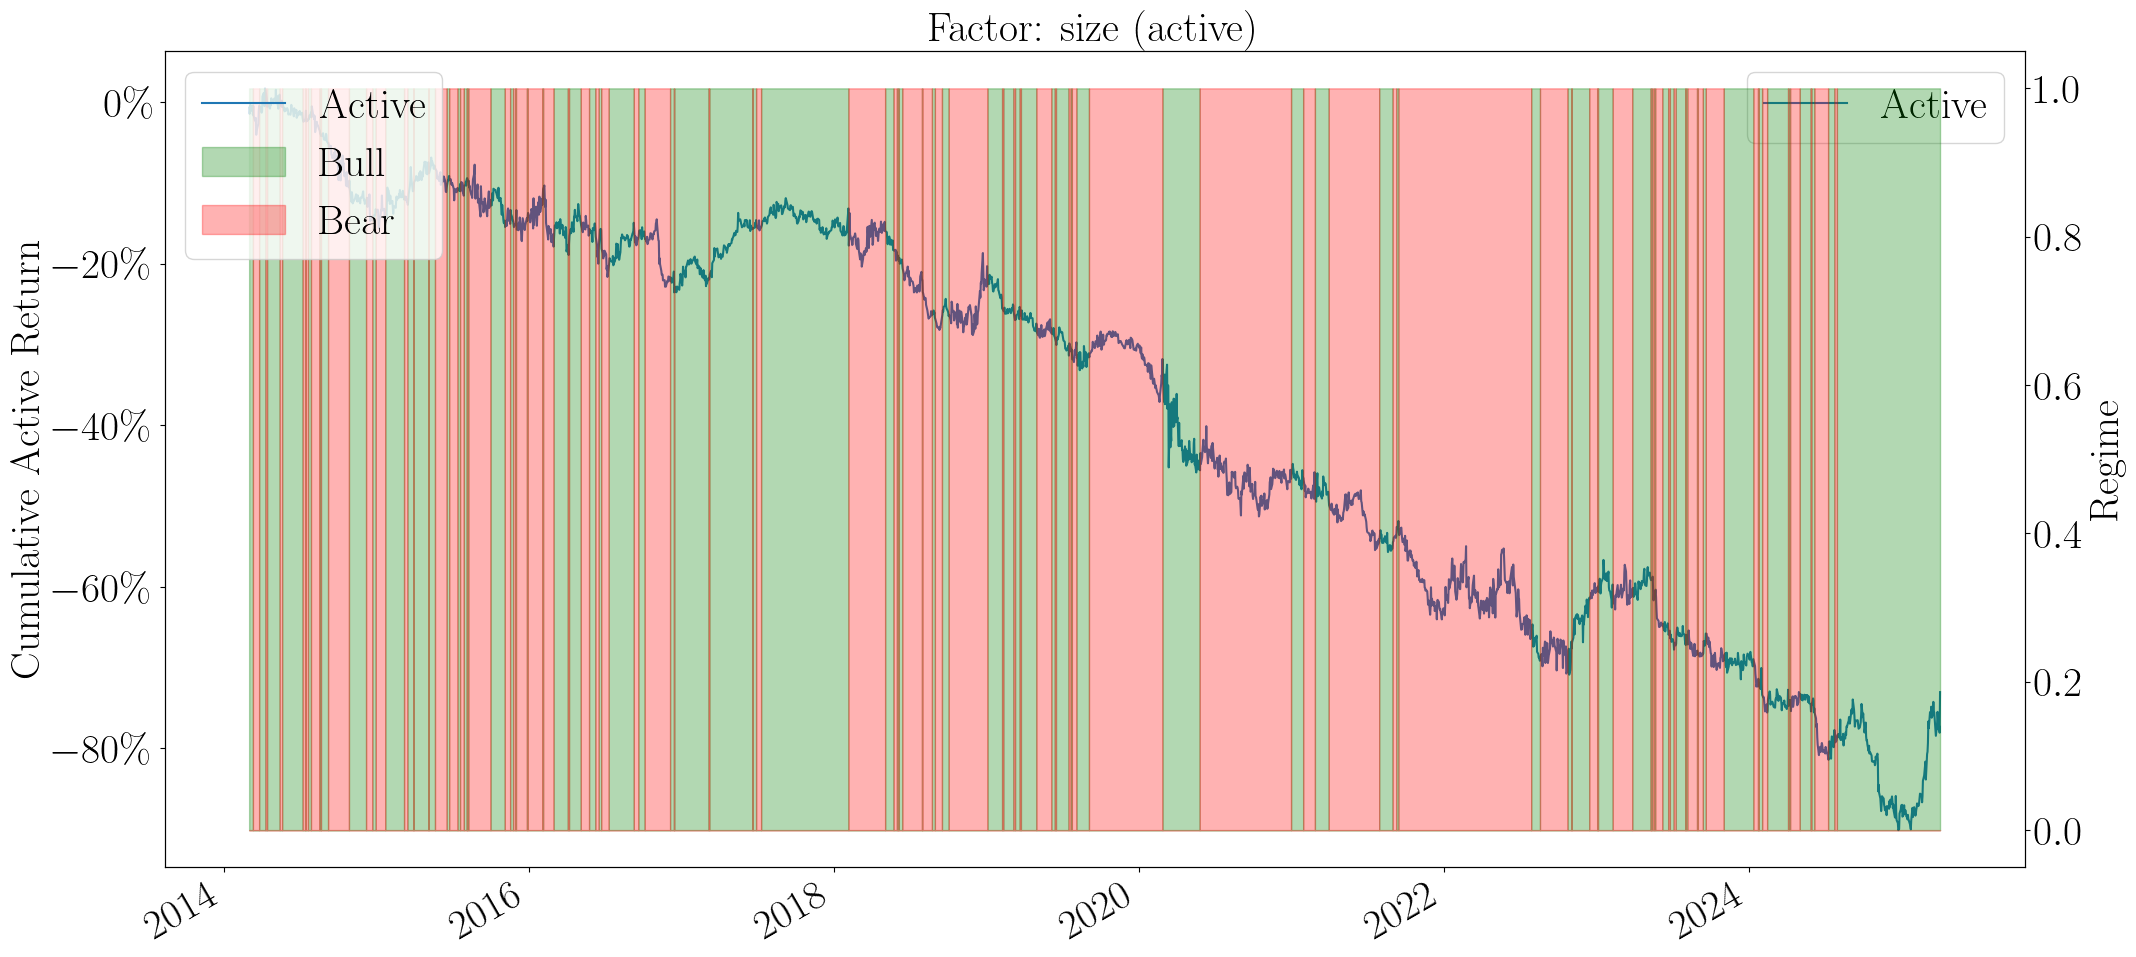

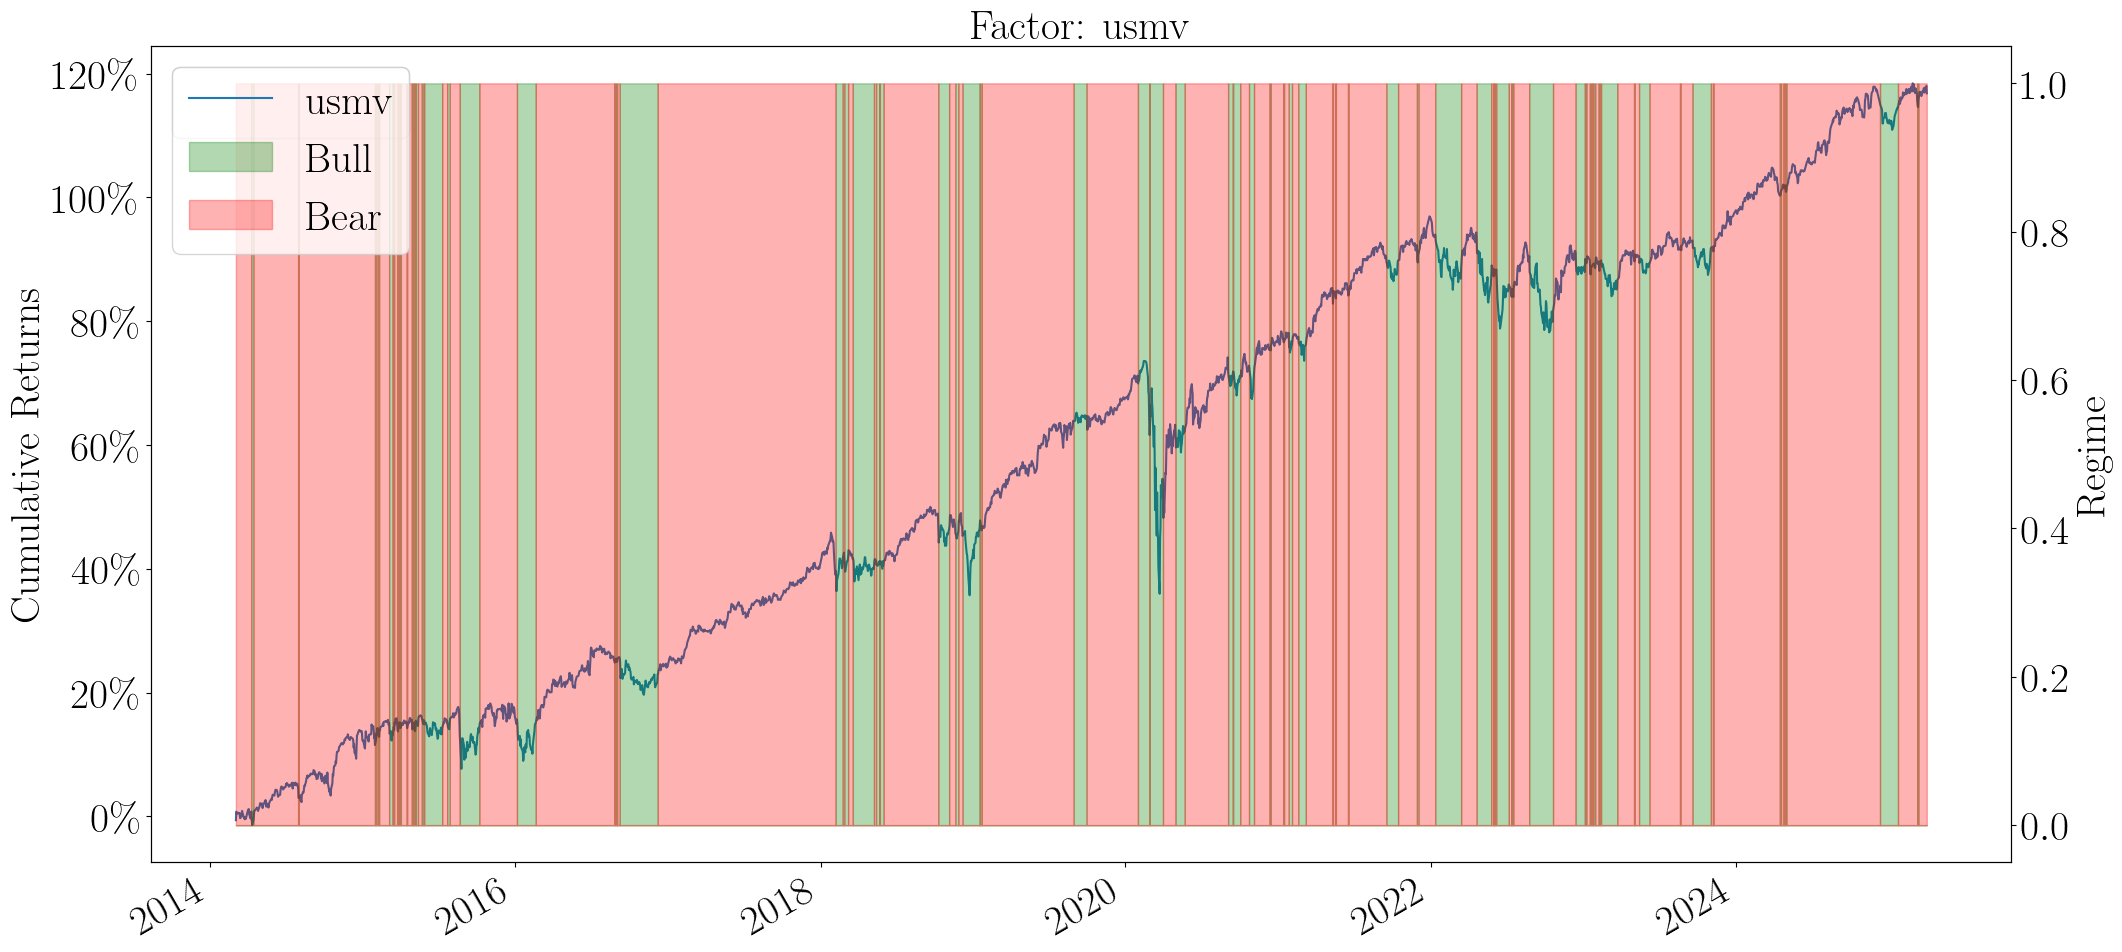

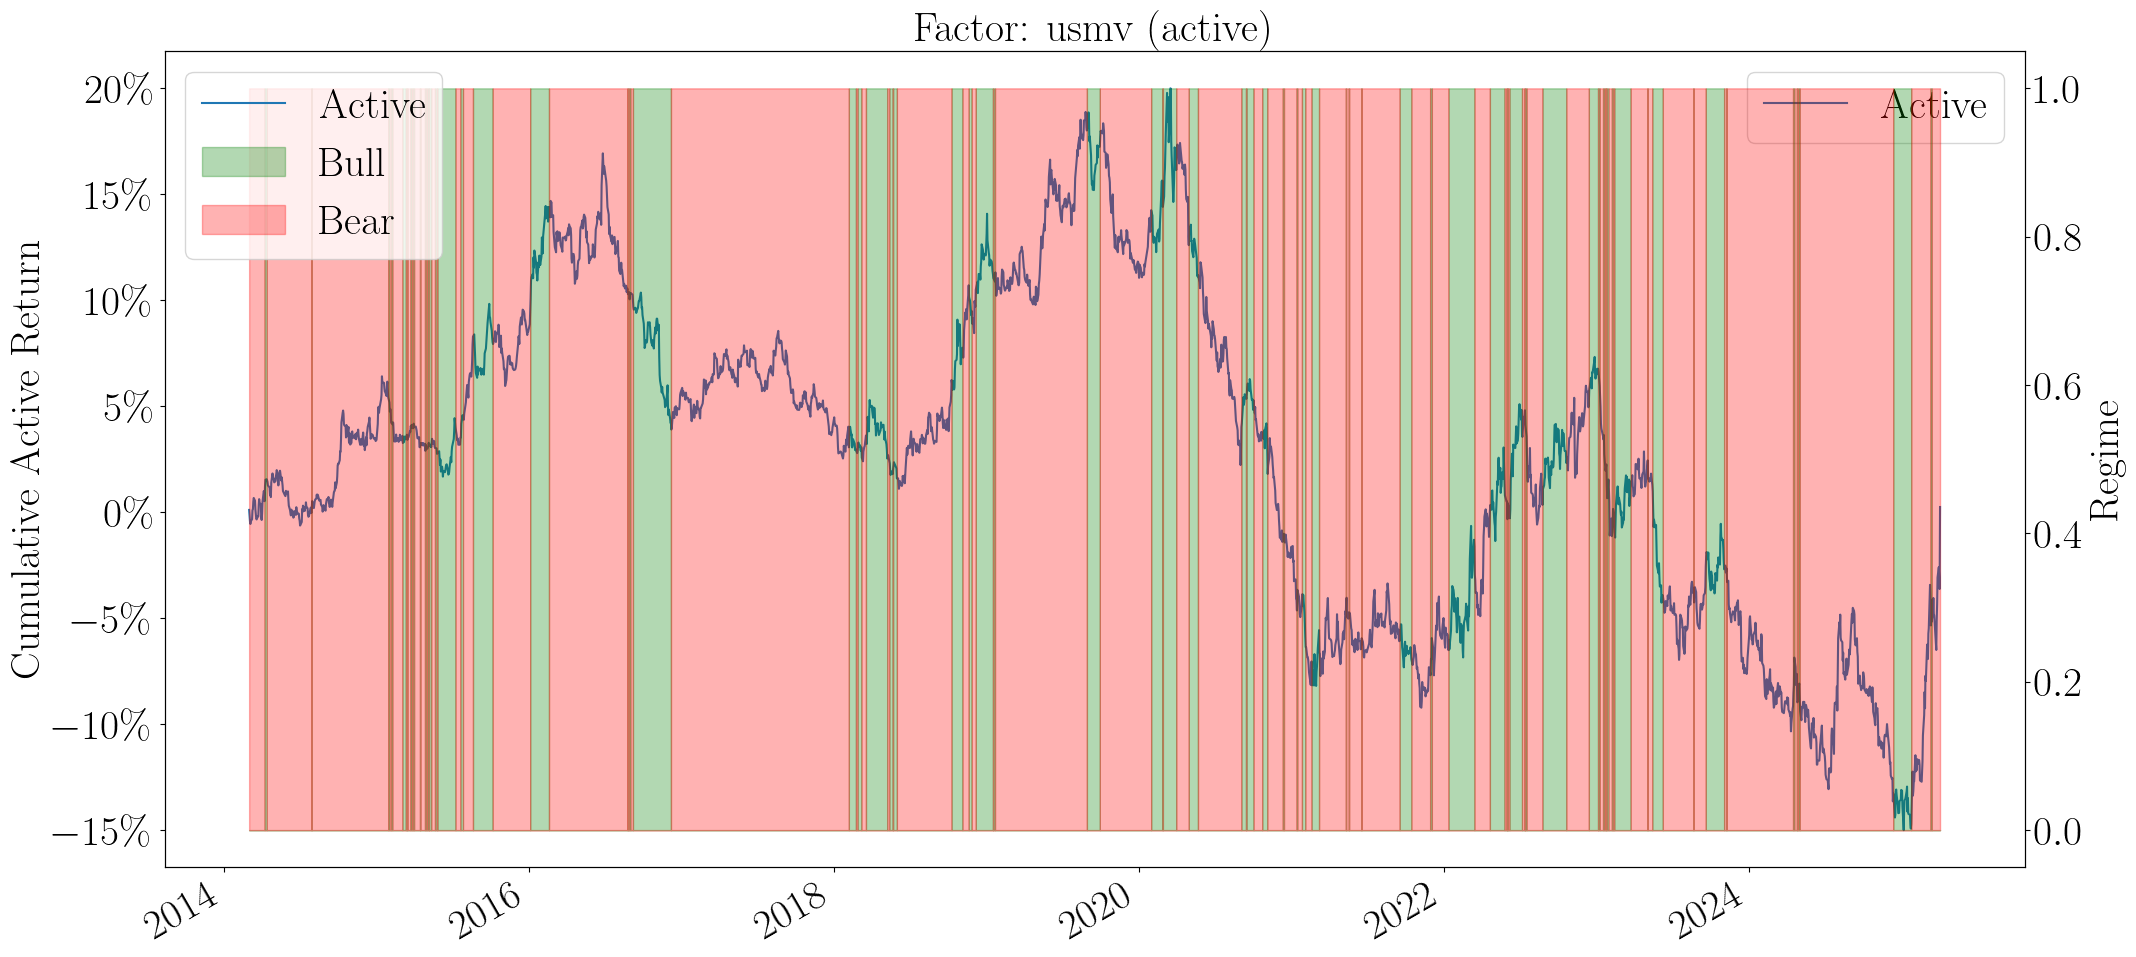

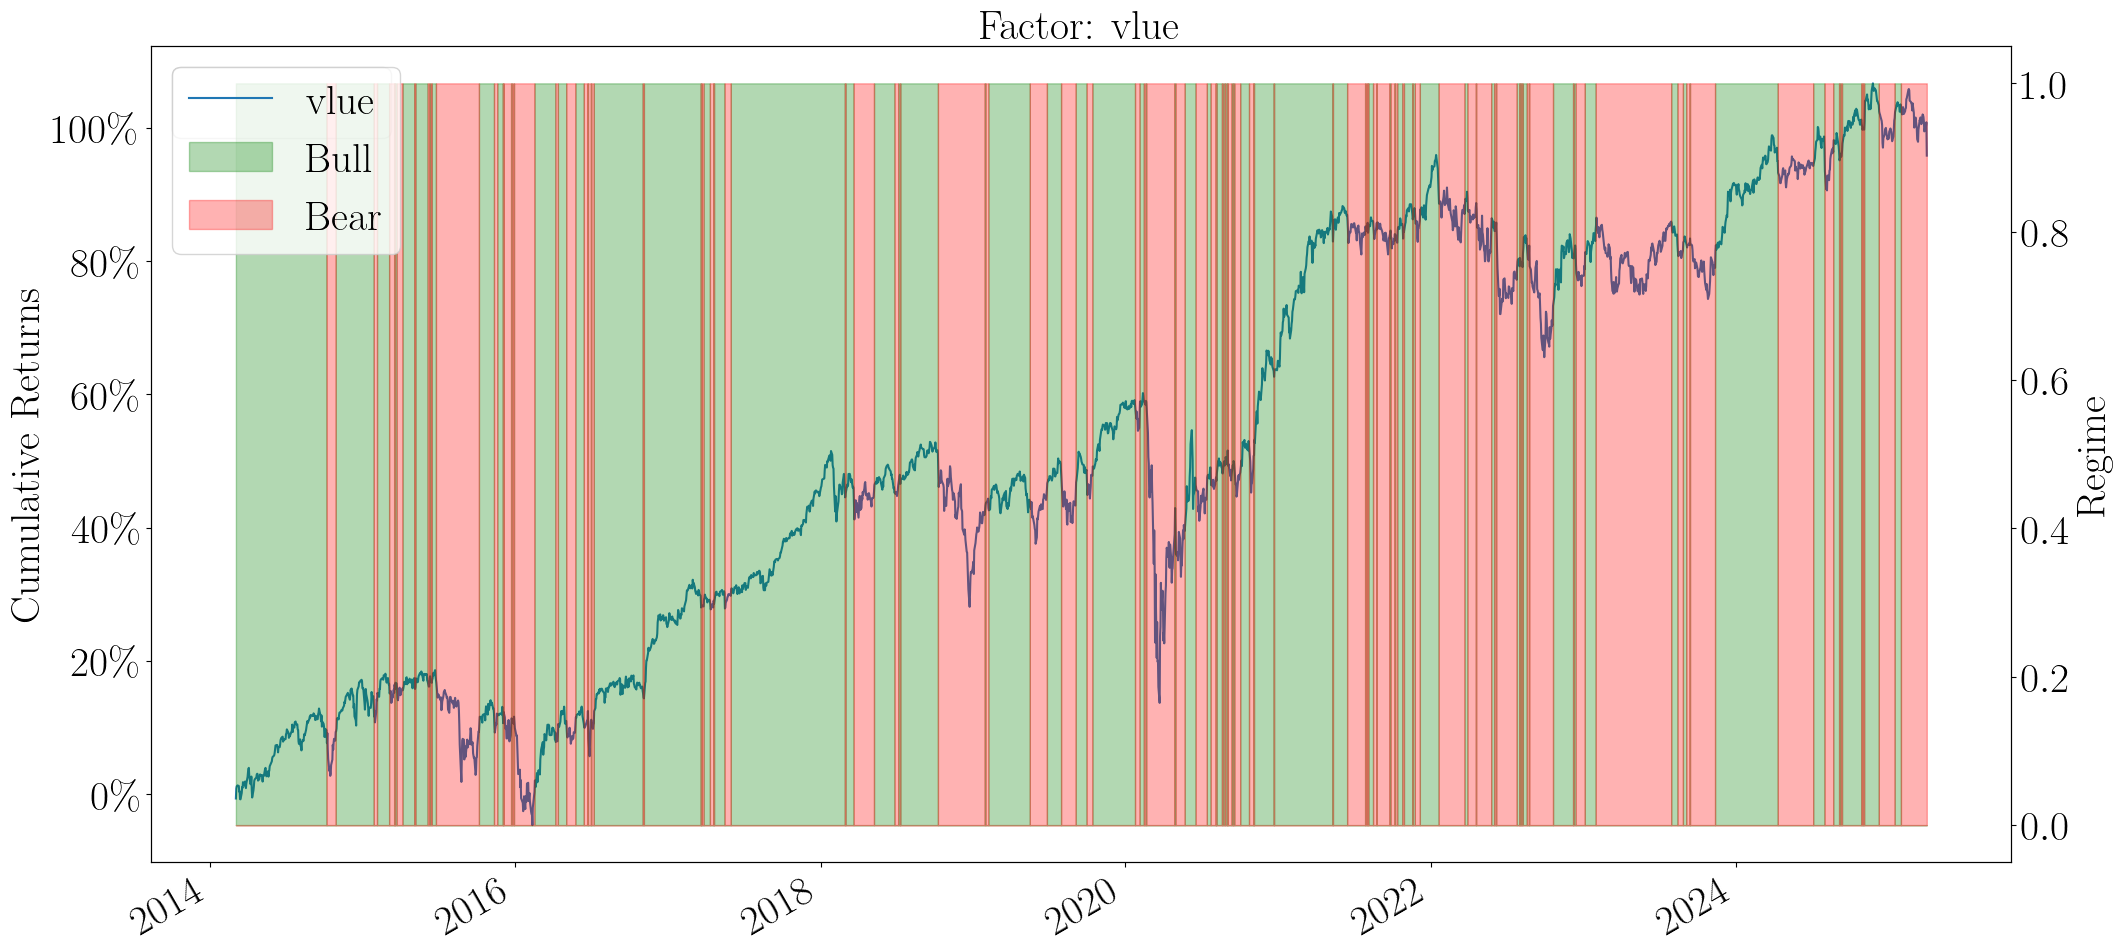

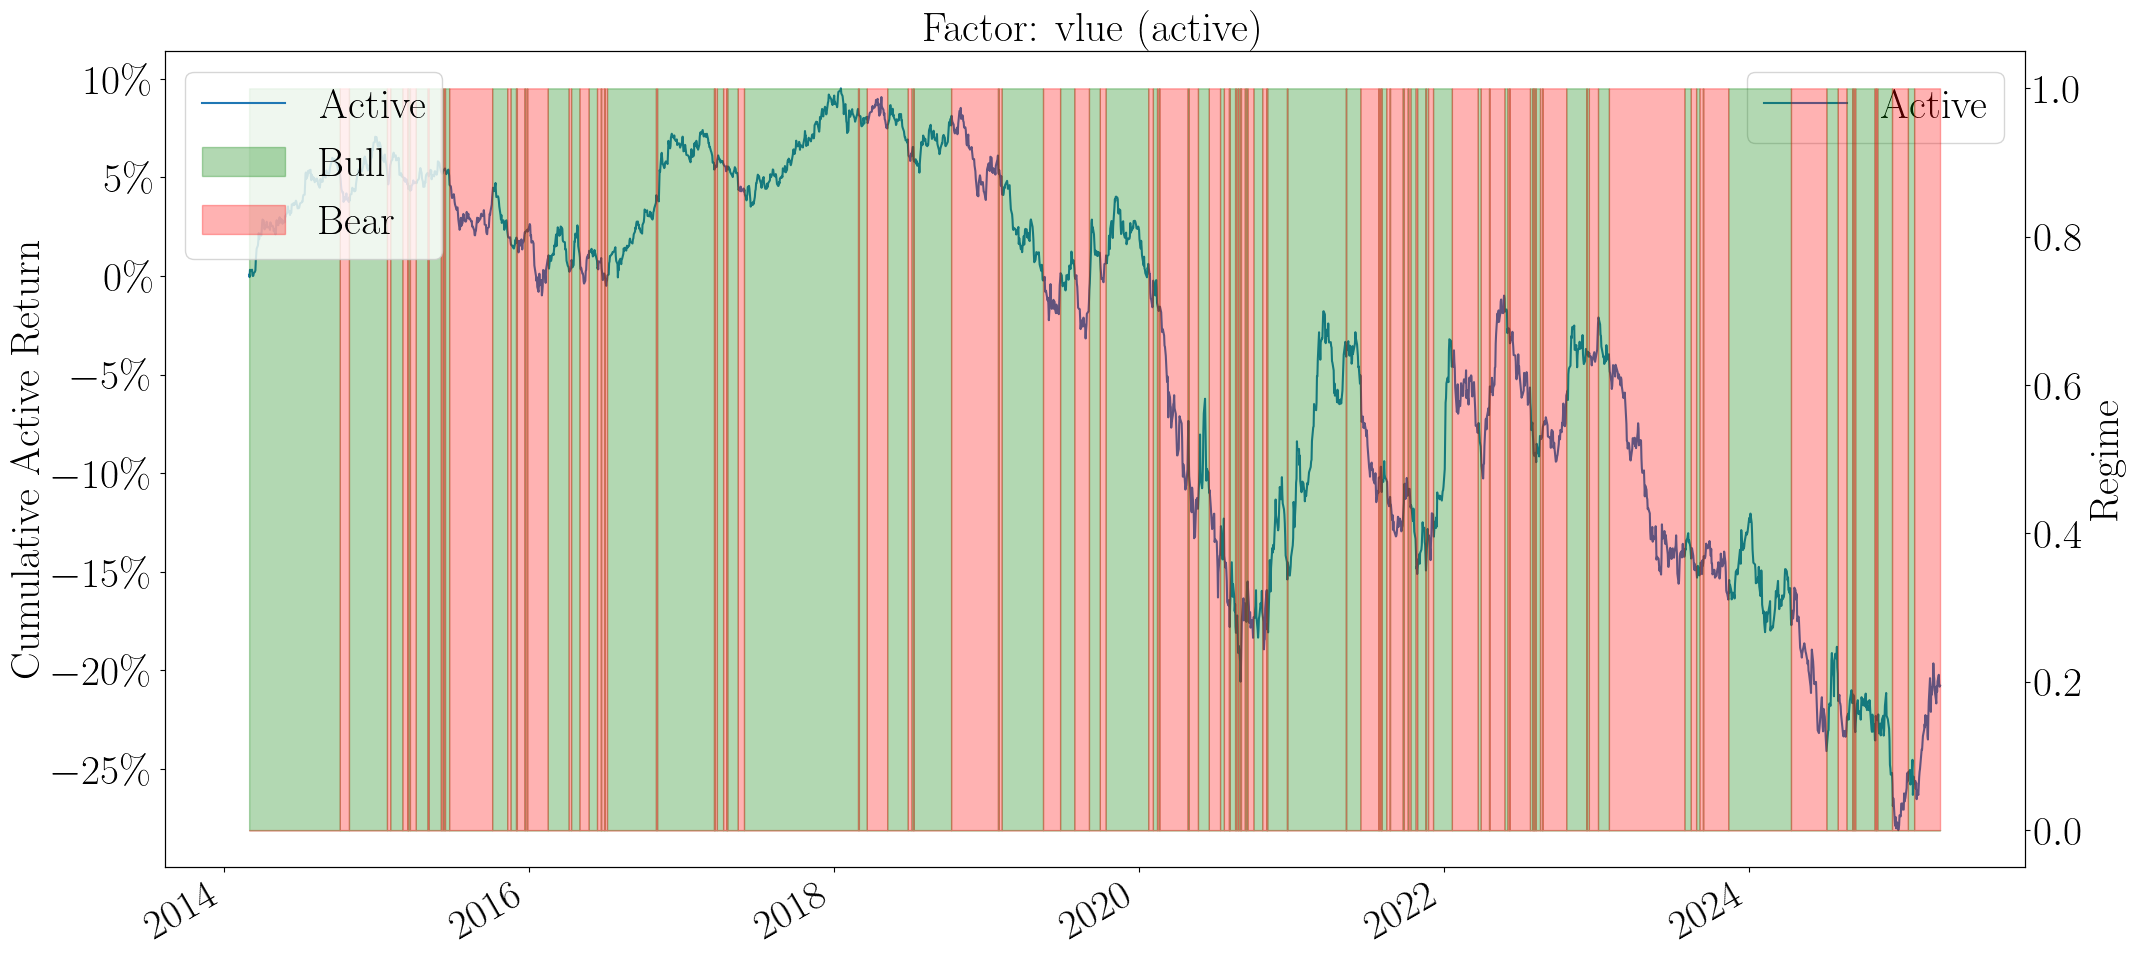

In [19]:
import matplotlib.pyplot as plt
from jumpmodels.plot import plot_regimes_and_cumret

for fac in factors:
    regimes     = factor_views[fac]["state"].dropna().astype(int)
    ret_raw     = factor_data_dict[fac]["fac_ret"].dropna()
    ret_active  = factor_data_dict[fac]["active_ret"].dropna()

    idx_raw    = regimes.index.intersection(ret_raw.index)
    idx_active = regimes.index.intersection(ret_active.index)

    # ---------- raw factor return ----------
    ax_raw, _ = plot_regimes_and_cumret(
        regimes.loc[idx_raw],
        ret_raw.loc[idx_raw],
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        legend_loc='upper left'
    )
    ax_raw.set_title(f"Factor: {fac}")
    plt.show()

    # ---------- active return ----------
    ax_act, _ = plot_regimes_and_cumret(
        regimes.loc[idx_active],
        ret_active.loc[idx_active].to_frame("Active"),
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        ylabel_ret="Cumulative Active Return",
        legend_loc='upper left'
    )
    ax_act.set_title(f"Factor: {fac} (active)")
    plt.show()

    
